In [98]:
from pyEDM import *
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable
import fiona
import rasterio.mask
from descartes import PolygonPatch
from rasterio.plot import show
from tqdm import tqdm
import datetime
import random
from osgeo import gdal, gdalconst
from scipy import stats

In [2]:
regionalization = '/home/rgreen/DroughtEDM/Data/Regionalization/'
clim_region_masks = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/ClimRegionMasks/'

In [3]:
observations_tables = '/home/rgreen/DroughtEDM/Data/observations_tables/'
transposed_predictions_tables = '/home/rgreen/tana-crunch/rgreen/crunch/DroughtEDM/Data/predictions_tables/'

In [4]:
ndvi_file = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/eMODIS_NDVI/Compressed/c_data.2002.071.tif'

In [5]:
env_var_dirs_anom = ['/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/CHIRPS/Anomaly/', 
               '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/eMODIS_NDVI/Anomaly/', 
                '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/LST/Anomaly/']

In [6]:
ea_boundary = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/AdminBoundaries/EastAfrica/EastAfrica.shp'

In [7]:
precip_anom_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/CHIRPS/Anomaly/'
temp_anom_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/LST/Anomaly/'
ndvi_anom_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/eMODIS_NDVI/Anomaly/'

# Clip regionalization raster to East Africa

In [17]:
def mask_raster_shp(shp, raster, out_name, in_dir, out_dir):
    
    '''
    This function masks a raster to the shape of a smaller shapefile and creates a new raster
    
    '''
    with fiona.open(shp, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]
    with rasterio.open(in_dir + raster) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, nodata = 0, crop=True)
        out_meta = src.meta

    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    with rasterio.open(out_dir + out_name, "w", **out_meta) as dest:
        #out_image = out_image.astype('float32')
        #out_image[out_image == 0] = np.nan  
        dest.write(out_image)

In [18]:
mask_raster_shp(ea_boundary, 'chirps-v2.0_1981-2014_Africa_0.25x0.25_AnnualCycle.tif', 'chirps-v2.0_1981-2014_Africa_0.25x0.25_AnnualCycle_EA.tif', regionalization, regionalization)

In [19]:
mask_raster_shp(ea_boundary, 'chirps-v2.0_1981-2014_Africa_0.25x0.25_AnnualMean.tif', 'chirps-v2.0_1981-2014_Africa_0.25x0.25_AnnualMean_EA.tif', regionalization, regionalization)

# Create binary mask for each region

In [24]:
def create_reg_mask(in_dir, filename, out_dir, clim_num):
    
    files=np.array(sorted(os.listdir(in_dir)))
    tifs = pd.Series(files).str.contains(filename)
    files = files[tifs]
    
    for filename in files:
        base = os.path.splitext(filename)[0]
        print(base)
        rast = rasterio.open(in_dir+filename)
        meta = rast.meta
        meta.update(dtype = 'float32', nodata = -3.4e+38)
        rast.close()
        
        with rasterio.open(out_dir+base+'_' + str(clim_num) + '.tif', 'w', **meta) as dst:
            with rasterio.open(in_dir+filename) as src:
                data = src.read()
                data = data.astype(np.float32)
                data[data!=clim_num] = np.nan
                data[data==clim_num] = 1
                dst.write(data)

In [40]:
create_reg_mask(regionalization, 'chirps_AnnualCycle_EA.tif', clim_region_masks, 12)

chirps_AnnualCycle_EA


# Resample regionalization raster to match variable data

In [42]:
def resample(in_dir, ref_file, out_dir, prefix):
    
    '''
    This function resamples rasters in a directory given a reference file's pixel size, projection and extent and creates new files in an out directory.
    '''
    
    files=np.array(sorted(os.listdir(in_dir)))
    tifs = pd.Series(files).str.contains('.tif')
    files = files[tifs]
    
    for filename in files:
        
        base = os.path.splitext(filename)[0]
        print(base)
        inputfile = in_dir + filename
        input = gdal.Open(inputfile, gdalconst.GA_ReadOnly)
        inputProj = input.GetProjection()
        inputTrans = input.GetGeoTransform()

        referencefile = ref_file
        reference = gdal.Open(referencefile, gdalconst.GA_ReadOnly)
        referenceProj = reference.GetProjection()
        referenceTrans = reference.GetGeoTransform()
        bandreference = reference.GetRasterBand(1)
        
        
#         x = reference.RasterXSize 
#         y = reference.RasterYSize
        
        x = 583
        y = 674


        outputfile = out_dir + prefix + base + '.tif' #change output file name for each variable
        driver= gdal.GetDriverByName('GTiff')
        output = driver.Create(outputfile,x,y,1,bandreference.DataType)
        output.SetGeoTransform((22, 0.05, 0.0, 22, 0.0, -0.05)) #edited here to get certain extent 
        output.SetProjection(referenceProj)
        
        gdal.ReprojectImage(input,output,inputProj,referenceProj,gdalconst.GRA_Bilinear)

        del output

In [47]:
resample(clim_region_masks, ndvi_file, clim_region_masks, 'rs_')

chirps_AnnualCycle_EA_01
chirps_AnnualCycle_EA_02
chirps_AnnualCycle_EA_03
chirps_AnnualCycle_EA_04
chirps_AnnualCycle_EA_06
chirps_AnnualCycle_EA_07
chirps_AnnualCycle_EA_08
chirps_AnnualCycle_EA_10
chirps_AnnualCycle_EA_11
chirps_AnnualCycle_EA_12


In [55]:
reg01 = clim_region_masks + 'rs_chirps_AnnualCycle_EA_01.tif'
reg02 = clim_region_masks + 'rs_chirps_AnnualCycle_EA_02.tif'
reg03 = clim_region_masks + 'rs_chirps_AnnualCycle_EA_03.tif'
reg04 = clim_region_masks + 'rs_chirps_AnnualCycle_EA_04.tif'
reg06 = clim_region_masks + 'rs_chirps_AnnualCycle_EA_06.tif'
reg07 = clim_region_masks + 'rs_chirps_AnnualCycle_EA_07.tif'
reg08 = clim_region_masks + 'rs_chirps_AnnualCycle_EA_08.tif'
reg10 = clim_region_masks + 'rs_chirps_AnnualCycle_EA_10.tif'
reg11 = clim_region_masks + 'rs_chirps_AnnualCycle_EA_11.tif'
reg12 = clim_region_masks + 'rs_chirps_AnnualCycle_EA_12.tif'

In [56]:
vars_reg01 = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByClimRegion/vars_reg01/'
vars_reg02 = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByClimRegion/vars_reg02/'
vars_reg03 = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByClimRegion/vars_reg03/'
vars_reg04 = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByClimRegion/vars_reg04/'
vars_reg06 = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByClimRegion/vars_reg06/'
vars_reg07 = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByClimRegion/vars_reg07/'
vars_reg08 = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByClimRegion/vars_reg08/'
vars_reg10 = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByClimRegion/vars_reg10/'
vars_reg11 = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByClimRegion/vars_reg11/'
vars_reg12 = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByClimRegion/vars_reg12/'

# Multiply variable rasters by region mask

In [57]:
def rastercalc_regionalization(reg_file, param_dir, out_dir, lc_name):
   
    reg_mask = rasterio.open(reg_file)

    
    for var in param_dir: 
        paramfiles = np.array(sorted(os.listdir(var)))
        tifs = pd.Series(paramfiles).str.contains('.tif') 
        files = paramfiles[tifs]
        
    
        for filename in files:
            var_rast = rasterio.open(var + filename)
            meta = var_rast.meta
            var_lcmask = var_rast.read(1)*reg_mask.read(1)
            with rasterio.open(out_dir + lc_name + filename, 'w', **meta) as dst: #change name depending on variable
                    dst.write(var_lcmask, 1)

In [65]:
rastercalc_regionalization(reg01, env_var_dirs_anom, vars_reg01, 'reg01_')
rastercalc_regionalization(reg02, env_var_dirs_anom, vars_reg02, 'reg02_')
rastercalc_regionalization(reg03, env_var_dirs_anom, vars_reg03, 'reg03_')
rastercalc_regionalization(reg04, env_var_dirs_anom, vars_reg04, 'reg04_')
rastercalc_regionalization(reg06, env_var_dirs_anom, vars_reg06, 'reg06_')
rastercalc_regionalization(reg07, env_var_dirs_anom, vars_reg07, 'reg07_')
rastercalc_regionalization(reg08, env_var_dirs_anom, vars_reg08, 'reg08_')
rastercalc_regionalization(reg10, env_var_dirs_anom, vars_reg10, 'reg10_')
rastercalc_regionalization(reg11, env_var_dirs_anom, vars_reg11, 'reg11_')
rastercalc_regionalization(reg12, env_var_dirs_anom, vars_reg12, 'reg12_')

# Generate observation dataframes

In [66]:
def pixelwise_ts_table(in_dir, keyword):
    
    '''
    This function searches through the file directory and creates a dataframe of pixel values over time from rasters
    based on a given keyword describing the environmental variable of interest to generate a raster time series stack 
    
   In the output dataframe, columns are each pixel extracted from the raster (read squentially into a list)
   and rows are the same pixel over time (dekads going down)
    
    Args:
    - in_dir: path to the input directory
    -keyword: string that is unique to the environmental variable
        options: ['precip', 'temp', 'ndvi']
    '''
    
    
    files=np.array(sorted(os.listdir(in_dir)))
    tifs = pd.Series(files).str.contains(keyword)
    files = files[tifs]
    #n_samples = len(files)
    
    
    pixelwise_TS = []
    
    for filename in tqdm(files): 
        
      
            open_file = xr.open_rasterio(in_dir+filename).sel(band=1)
            array = open_file.values

            pixel_list = array.ravel().tolist()
            
            pixelwise_TS.append(pixel_list)

    return pd.DataFrame(pixelwise_TS)

    

In [68]:
precip_reg01_table_anom = pixelwise_ts_table(vars_reg01, 'precip')

100%|██████████| 606/606 [00:09<00:00, 62.78it/s]


In [70]:
precip_reg02_table_anom = pixelwise_ts_table(vars_reg02, 'precip')
precip_reg03_table_anom = pixelwise_ts_table(vars_reg03, 'precip')
precip_reg04_table_anom = pixelwise_ts_table(vars_reg04, 'precip')
precip_reg06_table_anom = pixelwise_ts_table(vars_reg06, 'precip')
precip_reg07_table_anom = pixelwise_ts_table(vars_reg07, 'precip')
precip_reg08_table_anom = pixelwise_ts_table(vars_reg08, 'precip')
precip_reg10_table_anom = pixelwise_ts_table(vars_reg10, 'precip')
precip_reg11_table_anom = pixelwise_ts_table(vars_reg11, 'precip')
precip_reg12_table_anom = pixelwise_ts_table(vars_reg12, 'precip')

100%|██████████| 606/606 [00:08<00:00, 68.97it/s]


In [75]:
precip_table_anom = pixelwise_ts_table(precip_anom_dir, 'precip')
temp_table_anom = pixelwise_ts_table(temp_anom_dir, 'temp')
ndvi_table_anom = pixelwise_ts_table(ndvi_anom_dir, 'ndvi')

100%|██████████| 606/606 [00:10<00:00, 60.47it/s]


# Assign region identifier to pixels in observation dataframes

In [71]:
reg01_df = precip_reg01_table_anom
reg02_df = precip_reg02_table_anom
reg03_df = precip_reg03_table_anom
reg04_df = precip_reg04_table_anom
reg06_df = precip_reg06_table_anom
reg07_df = precip_reg07_table_anom
reg08_df = precip_reg08_table_anom
reg10_df = precip_reg10_table_anom
reg11_df = precip_reg11_table_anom
reg12_df = precip_reg12_table_anom

df_list = [precip_reg01_table_anom, precip_reg02_table_anom, precip_reg03_table_anom, precip_reg04_table_anom, precip_reg06_table_anom,
          precip_reg07_table_anom, precip_reg08_table_anom, precip_reg10_table_anom, precip_reg11_table_anom, precip_reg12_table_anom]

df_reg_list = []

for (df,reg) in zip(df_list,['reg01', 'reg02', 'reg03', 'reg04', 'reg06', 'reg07', 'reg08', 'reg10', 'reg11', 'reg12']):
    
    df_t = df.T
    df_t['Region'] = np.nan
    df_t.Region[df_t.iloc[:,0].notna()] = reg
    
    df_reg_list.append(df_t.Region.dropna())
    



In [85]:
precip_table_anom_reg = precip_table_anom.T.iloc[df_reg.index, :]
temp_table_anom_reg = temp_table_anom.T.iloc[df_reg.index, :]
ndvi_table_anom_reg = ndvi_table_anom.T.iloc[df_reg.index, :]

In [12]:
def generate_dekads(start, end):
    '''
    Generates list of timestamps of dekads between two dates
    
    Parameters
    ----------
    start : pd.datetime object
        Start date of list
    end : pd.datetime object
        end date of list
    '''
    
    dtrange = pd.date_range(start, end)
    days = list(range(len(dtrange))) #length of dtrange
    daysDF = pd.DataFrame({'Days': days}, index=dtrange)
    d = daysDF.index.day - np.clip((daysDF.index.day-1) // 10, 0, 2)*10 - 1 
    dekaddates = daysDF.index.values - np.array(d, dtype="timedelta64[D]")
    dekads = daysDF.groupby(dekaddates).mean()
    dekads = dekads.index
    
    return dekads

In [13]:
start = pd.datetime(2002,7,1)
end = pd.datetime(2019,4,30)

dekads = generate_dekads(start, end)

In [14]:
dekads_pi1 = generate_dekads(pd.datetime(2002,8, 21), pd.datetime(2019,5,1))
dekads_pi2 = generate_dekads(pd.datetime(2002,8, 21), pd.datetime(2019,5,11))
dekads_pi3 = generate_dekads(pd.datetime(2002,8, 21), pd.datetime(2019,5,21))
dekads_pi4 = generate_dekads(pd.datetime(2002,8, 21), pd.datetime(2019,6,1))
dekads_pi5 = generate_dekads(pd.datetime(2002,8, 21), pd.datetime(2019,6,11))
dekads_pi6 = generate_dekads(pd.datetime(2002,8, 21), pd.datetime(2019,6,21))
dekads_pi7 = generate_dekads(pd.datetime(2002,8, 21), pd.datetime(2019,7,1))
dekads_pi8 = generate_dekads(pd.datetime(2002,8, 21), pd.datetime(2019,7,11))
dekads_pi9 = generate_dekads(pd.datetime(2002,8, 21), pd.datetime(2019,7,21))
dekads_pi10 = generate_dekads(pd.datetime(2002,8, 21), pd.datetime(2019,8,1))
dekads_pi11 = generate_dekads(pd.datetime(2002,8, 21), pd.datetime(2019,8,11))
dekads_pi12 = generate_dekads(pd.datetime(2002,8, 21), pd.datetime(2019,8,21))

In [88]:
precip_table_anom_reg.columns= dekads.strftime("%Y-%m-%d").tolist()
temp_table_anom_reg.columns= dekads.strftime("%Y-%m-%d").tolist()
ndvi_table_anom_reg.columns= dekads.strftime("%Y-%m-%d").tolist()

In [89]:
precip_table_anom_reg.insert(0, 'reg', df_reg)
temp_table_anom_reg.insert(0, 'reg', df_reg)
ndvi_table_anom_reg.insert(0, 'reg', df_reg)

In [93]:
precip_table_anom_reg.index.name='pixel_id'
temp_table_anom_reg.index.name='pixel_id'
ndvi_table_anom_reg.index.name='pixel_id'

In [96]:
precip_table_anom_reg.to_csv(observations_tables + 'precip_table_anom_reg.csv')
temp_table_anom_reg.to_csv(observations_tables + 'temp_table_anom_reg.csv')
ndvi_table_anom_reg.to_csv(observations_tables + 'ndvi_table_anom_reg.csv')

# Load observation tables with region identifier

In [8]:
precip_table_anom_reg = pd.read_csv(observations_tables + 'precip_table_anom_reg.csv')
temp_table_anom_reg = pd.read_csv(observations_tables + 'temp_table_anom_reg.csv')
ndvi_table_anom_reg = pd.read_csv(observations_tables + 'ndvi_table_anom_reg.csv')


In [41]:
reg_pixels = ndvi_table_anom_reg.pixel_id.tolist()
reg_col = ndvi_table_anom_reg.reg

# Load prediction tables and insert region identifier

In [10]:
ndvi_ea_simplex_ed6_pi1T = pd.read_csv(transposed_predictions_tables + 'ndvi_ea_simplex_ed6_pi1T.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
ndvi_ea_simplex_ed6_pi2T = pd.read_csv(transposed_predictions_tables + 'ndvi_ea_simplex_ed6_pi2T.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
ndvi_ea_simplex_ed6_pi3T = pd.read_csv(transposed_predictions_tables + 'ndvi_ea_simplex_ed6_pi3T.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
ndvi_ea_simplex_ed6_pi4T = pd.read_csv(transposed_predictions_tables + 'ndvi_ea_simplex_ed6_pi4T.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
ndvi_ea_simplex_ed6_pi5T = pd.read_csv(transposed_predictions_tables + 'ndvi_ea_simplex_ed6_pi5T.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
ndvi_ea_simplex_ed6_pi6T = pd.read_csv(transposed_predictions_tables + 'ndvi_ea_simplex_ed6_pi6T.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
ndvi_ea_simplex_ed6_pi7T = pd.read_csv(transposed_predictions_tables + 'ndvi_ea_simplex_ed6_pi7T.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
ndvi_ea_simplex_ed6_pi8T = pd.read_csv(transposed_predictions_tables + 'ndvi_ea_simplex_ed6_pi8T.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
ndvi_ea_simplex_ed6_pi9T = pd.read_csv(transposed_predictions_tables + 'ndvi_ea_simplex_ed6_pi9T.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
ndvi_ea_simplex_ed6_pi10T = pd.read_csv(transposed_predictions_tables + 'ndvi_ea_simplex_ed6_pi10T.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
ndvi_ea_simplex_ed6_pi11T = pd.read_csv(transposed_predictions_tables + 'ndvi_ea_simplex_ed6_pi11T.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])
ndvi_ea_simplex_ed6_pi12T = pd.read_csv(transposed_predictions_tables + 'ndvi_ea_simplex_ed6_pi12T.csv', delimiter=',', engine='c', low_memory=False, index_col=[0])

In [17]:
ndvi_ea_simplex_ed6_pi1T.columns = dekads_pi1.strftime("%Y-%m-%d").tolist()
ndvi_ea_simplex_ed6_pi2T.columns = dekads_pi2.strftime("%Y-%m-%d").tolist()
ndvi_ea_simplex_ed6_pi3T.columns = dekads_pi3.strftime("%Y-%m-%d").tolist()
ndvi_ea_simplex_ed6_pi4T.columns = dekads_pi4.strftime("%Y-%m-%d").tolist()
ndvi_ea_simplex_ed6_pi5T.columns = dekads_pi5.strftime("%Y-%m-%d").tolist()
ndvi_ea_simplex_ed6_pi6T.columns = dekads_pi6.strftime("%Y-%m-%d").tolist()
ndvi_ea_simplex_ed6_pi7T.columns = dekads_pi7.strftime("%Y-%m-%d").tolist()
ndvi_ea_simplex_ed6_pi8T.columns = dekads_pi8.strftime("%Y-%m-%d").tolist()
ndvi_ea_simplex_ed6_pi9T.columns = dekads_pi9.strftime("%Y-%m-%d").tolist()
ndvi_ea_simplex_ed6_pi10T.columns = dekads_pi10.strftime("%Y-%m-%d").tolist()
ndvi_ea_simplex_ed6_pi11T.columns = dekads_pi11.strftime("%Y-%m-%d").tolist()
ndvi_ea_simplex_ed6_pi12T.columns = dekads_pi12.strftime("%Y-%m-%d").tolist()

In [147]:
ndvi_ea_simplex_ed6_pi1T_reg = ndvi_ea_simplex_ed6_pi1T.loc[reg_pixels]
ndvi_ea_simplex_ed6_pi2T_reg = ndvi_ea_simplex_ed6_pi2T.loc[reg_pixels]
ndvi_ea_simplex_ed6_pi3T_reg = ndvi_ea_simplex_ed6_pi3T.loc[reg_pixels]
ndvi_ea_simplex_ed6_pi4T_reg = ndvi_ea_simplex_ed6_pi4T.loc[reg_pixels]
ndvi_ea_simplex_ed6_pi5T_reg = ndvi_ea_simplex_ed6_pi5T.loc[reg_pixels]
ndvi_ea_simplex_ed6_pi6T_reg = ndvi_ea_simplex_ed6_pi6T.loc[reg_pixels]
ndvi_ea_simplex_ed6_pi7T_reg = ndvi_ea_simplex_ed6_pi7T.loc[reg_pixels]
ndvi_ea_simplex_ed6_pi8T_reg = ndvi_ea_simplex_ed6_pi8T.loc[reg_pixels]
ndvi_ea_simplex_ed6_pi9T_reg = ndvi_ea_simplex_ed6_pi9T.loc[reg_pixels]
ndvi_ea_simplex_ed6_pi10T_reg = ndvi_ea_simplex_ed6_pi10T.loc[reg_pixels]
ndvi_ea_simplex_ed6_pi11T_reg = ndvi_ea_simplex_ed6_pi11T.loc[reg_pixels]
ndvi_ea_simplex_ed6_pi12T_reg = ndvi_ea_simplex_ed6_pi12T.loc[reg_pixels]

In [148]:
ndvi_ea_simplex_ed6_pi1T_reg.index.name='pixel_id'
ndvi_ea_simplex_ed6_pi2T_reg.index.name='pixel_id'
ndvi_ea_simplex_ed6_pi3T_reg.index.name='pixel_id'
ndvi_ea_simplex_ed6_pi4T_reg.index.name='pixel_id'
ndvi_ea_simplex_ed6_pi5T_reg.index.name='pixel_id'
ndvi_ea_simplex_ed6_pi6T_reg.index.name='pixel_id'
ndvi_ea_simplex_ed6_pi7T_reg.index.name='pixel_id'
ndvi_ea_simplex_ed6_pi8T_reg.index.name='pixel_id'
ndvi_ea_simplex_ed6_pi9T_reg.index.name='pixel_id'
ndvi_ea_simplex_ed6_pi10T_reg.index.name='pixel_id'
ndvi_ea_simplex_ed6_pi11T_reg.index.name='pixel_id'
ndvi_ea_simplex_ed6_pi12T_reg.index.name='pixel_id'

In [149]:
ndvi_ea_simplex_ed6_pi1T_reg = ndvi_ea_simplex_ed6_pi1T_reg.reset_index()
ndvi_ea_simplex_ed6_pi2T_reg = ndvi_ea_simplex_ed6_pi2T_reg.reset_index()
ndvi_ea_simplex_ed6_pi3T_reg = ndvi_ea_simplex_ed6_pi3T_reg.reset_index()
ndvi_ea_simplex_ed6_pi4T_reg = ndvi_ea_simplex_ed6_pi4T_reg.reset_index()
ndvi_ea_simplex_ed6_pi5T_reg = ndvi_ea_simplex_ed6_pi5T_reg.reset_index()
ndvi_ea_simplex_ed6_pi6T_reg = ndvi_ea_simplex_ed6_pi6T_reg.reset_index()
ndvi_ea_simplex_ed6_pi7T_reg = ndvi_ea_simplex_ed6_pi7T_reg.reset_index()
ndvi_ea_simplex_ed6_pi8T_reg = ndvi_ea_simplex_ed6_pi8T_reg.reset_index()
ndvi_ea_simplex_ed6_pi9T_reg = ndvi_ea_simplex_ed6_pi9T_reg.reset_index()
ndvi_ea_simplex_ed6_pi10T_reg = ndvi_ea_simplex_ed6_pi10T_reg.reset_index()
ndvi_ea_simplex_ed6_pi11T_reg = ndvi_ea_simplex_ed6_pi11T_reg.reset_index()
ndvi_ea_simplex_ed6_pi12T_reg = ndvi_ea_simplex_ed6_pi12T_reg.reset_index()

In [151]:
ndvi_ea_simplex_ed6_pi2T_reg

,pixel_id,2002-08-21,2002-09-01,2002-09-11,2002-09-21,2002-10-01,2002-10-11,2002-10-21,2002-11-01,2002-11-11,...,2019-02-11,2019-02-21,2019-03-01,2019-03-11,2019-03-21,2019-04-01,2019-04-11,2019-04-21,2019-05-01,2019-05-11
0,51622,NaN,NaN,-0.365358,-0.031550,0.456228,0.507899,0.641063,0.618585,-0.128363,...,-0.157040,-0.295687,-0.381515,-0.509993,-0.628591,-0.827780,-0.693459,-0.594874,-0.700417,-0.558005
1,51623,NaN,NaN,-0.066976,0.027910,0.554087,0.136322,0.197477,0.011880,-0.681332,...,0.022755,-0.202696,-0.249157,-0.348405,-0.548786,-0.638656,-0.559760,-0.590840,-0.599226,-0.526270
2,51624,NaN,NaN,-0.215623,0.242346,0.159048,0.001546,-0.016210,0.010307,-0.235296,...,0.150775,-0.076281,-0.148283,-0.404396,-0.809239,-0.926571,-0.856581,-0.783034,-0.793480,-0.651685
3,51625,NaN,NaN,0.026308,0.594137,0.524595,0.502414,0.488926,0.432298,0.747445,...,-0.007592,-0.134764,-0.323757,-0.550221,-0.786864,-1.056634,-1.102706,-1.036969,-1.108464,-0.939738
4,51626,NaN,NaN,0.556430,0.496308,0.858607,0.660312,0.449388,0.249573,0.417965,...,0.131366,-0.077387,-0.337410,-0.437158,-0.721959,-0.965462,-1.063803,-1.074842,-1.135727,-1.134876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134080,336724,NaN,NaN,-0.491509,-0.707753,-0.845783,-1.182031,-1.303210,-1.476296,-1.253456,...,-0.042281,-0.023240,-0.142633,0.216493,0.413684,0.570472,0.690369,0.801924,0.753220,0.936326
134081,336725,NaN,NaN,0.054495,-0.154001,-0.102217,-0.421662,-0.848860,-1.337432,-1.506133,...,0.125727,0.096968,-0.017937,0.289442,0.546090,0.622175,0.630241,0.812685,0.798469,0.686259
134082,336726,NaN,NaN,-0.015492,-0.099251,-0.164875,-0.552405,-0.987386,-1.124517,-1.045843,...,0.250741,0.115267,0.336705,0.290261,0.654968,0.494900,0.519808,0.718368,0.664666,0.497382
134083,336727,NaN,NaN,0.151678,0.011421,0.024533,-0.157458,-0.674141,-0.565209,-0.394418,...,0.510185,0.208672,0.610036,0.633212,0.565131,0.669421,0.682046,0.812398,1.006337,0.753540


In [152]:
ndvi_ea_simplex_ed6_pi1T_reg.insert(0, 'reg', reg_col)
ndvi_ea_simplex_ed6_pi2T_reg.insert(0, 'reg', reg_col)
ndvi_ea_simplex_ed6_pi3T_reg.insert(0, 'reg', reg_col)
ndvi_ea_simplex_ed6_pi4T_reg.insert(0, 'reg', reg_col)
ndvi_ea_simplex_ed6_pi5T_reg.insert(0, 'reg', reg_col)
ndvi_ea_simplex_ed6_pi6T_reg.insert(0, 'reg', reg_col)
ndvi_ea_simplex_ed6_pi7T_reg.insert(0, 'reg', reg_col)
ndvi_ea_simplex_ed6_pi8T_reg.insert(0, 'reg', reg_col)
ndvi_ea_simplex_ed6_pi9T_reg.insert(0, 'reg', reg_col)
ndvi_ea_simplex_ed6_pi10T_reg.insert(0, 'reg', reg_col)
ndvi_ea_simplex_ed6_pi11T_reg.insert(0, 'reg', reg_col)
ndvi_ea_simplex_ed6_pi12T_reg.insert(0, 'reg', reg_col)

# Subset observations and predictions tables to regional dataframes

In [154]:
first_cols= ['2002-07-01', '2002-07-11', '2002-07-21', '2002-08-01', '2002-08-11']

In [155]:
ndvi_table_anom_reg01 = ndvi_table_anom_reg.loc[ndvi_table_anom_reg['reg'] == 'reg01'].drop(first_cols,axis=1).iloc[:, 2:]
ndvi_table_anom_reg02 = ndvi_table_anom_reg.loc[ndvi_table_anom_reg['reg'] == 'reg02'].drop(first_cols,axis=1).iloc[:, 2:]
ndvi_table_anom_reg03 = ndvi_table_anom_reg.loc[ndvi_table_anom_reg['reg'] == 'reg03'].drop(first_cols,axis=1).iloc[:, 2:]
ndvi_table_anom_reg04 = ndvi_table_anom_reg.loc[ndvi_table_anom_reg['reg'] == 'reg04'].drop(first_cols,axis=1).iloc[:, 2:]
ndvi_table_anom_reg06 = ndvi_table_anom_reg.loc[ndvi_table_anom_reg['reg'] == 'reg06'].drop(first_cols,axis=1).iloc[:, 2:]
ndvi_table_anom_reg07 = ndvi_table_anom_reg.loc[ndvi_table_anom_reg['reg'] == 'reg07'].drop(first_cols,axis=1).iloc[:, 2:]
ndvi_table_anom_reg08 = ndvi_table_anom_reg.loc[ndvi_table_anom_reg['reg'] == 'reg08'].drop(first_cols,axis=1).iloc[:, 2:]
ndvi_table_anom_reg10 = ndvi_table_anom_reg.loc[ndvi_table_anom_reg['reg'] == 'reg10'].drop(first_cols,axis=1).iloc[:, 2:]
ndvi_table_anom_reg11 = ndvi_table_anom_reg.loc[ndvi_table_anom_reg['reg'] == 'reg11'].drop(first_cols,axis=1).iloc[:, 2:]
ndvi_table_anom_reg12 = ndvi_table_anom_reg.loc[ndvi_table_anom_reg['reg'] == 'reg12'].drop(first_cols,axis=1).iloc[:, 2:]

In [156]:
ndvi_simplex_pi1T_reg01 = ndvi_ea_simplex_ed6_pi1T_reg.loc[ndvi_ea_simplex_ed6_pi1T_reg['reg'] =='reg01'].iloc[:, 2:]
ndvi_simplex_pi2T_reg01 = ndvi_ea_simplex_ed6_pi2T_reg.loc[ndvi_ea_simplex_ed6_pi2T_reg['reg'] =='reg01'].iloc[:, 2:]
ndvi_simplex_pi3T_reg01 = ndvi_ea_simplex_ed6_pi3T_reg.loc[ndvi_ea_simplex_ed6_pi3T_reg['reg'] =='reg01'].iloc[:, 2:]
ndvi_simplex_pi4T_reg01 = ndvi_ea_simplex_ed6_pi4T_reg.loc[ndvi_ea_simplex_ed6_pi4T_reg['reg'] =='reg01'].iloc[:, 2:]
ndvi_simplex_pi5T_reg01 = ndvi_ea_simplex_ed6_pi5T_reg.loc[ndvi_ea_simplex_ed6_pi5T_reg['reg'] =='reg01'].iloc[:, 2:]
ndvi_simplex_pi6T_reg01 = ndvi_ea_simplex_ed6_pi6T_reg.loc[ndvi_ea_simplex_ed6_pi6T_reg['reg'] =='reg01'].iloc[:, 2:]
ndvi_simplex_pi7T_reg01 = ndvi_ea_simplex_ed6_pi7T_reg.loc[ndvi_ea_simplex_ed6_pi7T_reg['reg'] =='reg01'].iloc[:, 2:]
ndvi_simplex_pi8T_reg01 = ndvi_ea_simplex_ed6_pi8T_reg.loc[ndvi_ea_simplex_ed6_pi8T_reg['reg'] =='reg01'].iloc[:, 2:]
ndvi_simplex_pi9T_reg01 = ndvi_ea_simplex_ed6_pi9T_reg.loc[ndvi_ea_simplex_ed6_pi9T_reg['reg'] =='reg01'].iloc[:, 2:]
ndvi_simplex_pi10T_reg01 = ndvi_ea_simplex_ed6_pi10T_reg.loc[ndvi_ea_simplex_ed6_pi10T_reg['reg'] =='reg01'].iloc[:, 2:]
ndvi_simplex_pi11T_reg01 = ndvi_ea_simplex_ed6_pi11T_reg.loc[ndvi_ea_simplex_ed6_pi11T_reg['reg'] =='reg01'].iloc[:, 2:]
ndvi_simplex_pi12T_reg01 = ndvi_ea_simplex_ed6_pi12T_reg.loc[ndvi_ea_simplex_ed6_pi12T_reg['reg'] =='reg01'].iloc[:, 2:]

ndvi_simplex_pi1T_reg02 = ndvi_ea_simplex_ed6_pi1T_reg.loc[ndvi_ea_simplex_ed6_pi1T_reg['reg'] =='reg02'].iloc[:, 2:]
ndvi_simplex_pi2T_reg02 = ndvi_ea_simplex_ed6_pi2T_reg.loc[ndvi_ea_simplex_ed6_pi2T_reg['reg'] =='reg02'].iloc[:, 2:]
ndvi_simplex_pi3T_reg02 = ndvi_ea_simplex_ed6_pi3T_reg.loc[ndvi_ea_simplex_ed6_pi3T_reg['reg'] =='reg02'].iloc[:, 2:]
ndvi_simplex_pi4T_reg02 = ndvi_ea_simplex_ed6_pi4T_reg.loc[ndvi_ea_simplex_ed6_pi4T_reg['reg'] =='reg02'].iloc[:, 2:]
ndvi_simplex_pi5T_reg02 = ndvi_ea_simplex_ed6_pi5T_reg.loc[ndvi_ea_simplex_ed6_pi5T_reg['reg'] =='reg02'].iloc[:, 2:]
ndvi_simplex_pi6T_reg02 = ndvi_ea_simplex_ed6_pi6T_reg.loc[ndvi_ea_simplex_ed6_pi6T_reg['reg'] =='reg02'].iloc[:, 2:]
ndvi_simplex_pi7T_reg02 = ndvi_ea_simplex_ed6_pi7T_reg.loc[ndvi_ea_simplex_ed6_pi7T_reg['reg'] =='reg02'].iloc[:, 2:]
ndvi_simplex_pi8T_reg02 = ndvi_ea_simplex_ed6_pi8T_reg.loc[ndvi_ea_simplex_ed6_pi8T_reg['reg'] =='reg02'].iloc[:, 2:]
ndvi_simplex_pi9T_reg02 = ndvi_ea_simplex_ed6_pi9T_reg.loc[ndvi_ea_simplex_ed6_pi9T_reg['reg'] =='reg02'].iloc[:, 2:]
ndvi_simplex_pi10T_reg02 = ndvi_ea_simplex_ed6_pi10T_reg.loc[ndvi_ea_simplex_ed6_pi10T_reg['reg'] =='reg02'].iloc[:, 2:]
ndvi_simplex_pi11T_reg02 = ndvi_ea_simplex_ed6_pi11T_reg.loc[ndvi_ea_simplex_ed6_pi11T_reg['reg'] =='reg02'].iloc[:, 2:]
ndvi_simplex_pi12T_reg02 = ndvi_ea_simplex_ed6_pi12T_reg.loc[ndvi_ea_simplex_ed6_pi12T_reg['reg'] =='reg02'].iloc[:, 2:]

ndvi_simplex_pi1T_reg03 = ndvi_ea_simplex_ed6_pi1T_reg.loc[ndvi_ea_simplex_ed6_pi1T_reg['reg'] =='reg03'].iloc[:, 2:]
ndvi_simplex_pi2T_reg03 = ndvi_ea_simplex_ed6_pi2T_reg.loc[ndvi_ea_simplex_ed6_pi2T_reg['reg'] =='reg03'].iloc[:, 2:]
ndvi_simplex_pi3T_reg03 = ndvi_ea_simplex_ed6_pi3T_reg.loc[ndvi_ea_simplex_ed6_pi3T_reg['reg'] =='reg03'].iloc[:, 2:]
ndvi_simplex_pi4T_reg03 = ndvi_ea_simplex_ed6_pi4T_reg.loc[ndvi_ea_simplex_ed6_pi4T_reg['reg'] =='reg03'].iloc[:, 2:]
ndvi_simplex_pi5T_reg03 = ndvi_ea_simplex_ed6_pi5T_reg.loc[ndvi_ea_simplex_ed6_pi5T_reg['reg'] =='reg03'].iloc[:, 2:]
ndvi_simplex_pi6T_reg03 = ndvi_ea_simplex_ed6_pi6T_reg.loc[ndvi_ea_simplex_ed6_pi6T_reg['reg'] =='reg03'].iloc[:, 2:]
ndvi_simplex_pi7T_reg03 = ndvi_ea_simplex_ed6_pi7T_reg.loc[ndvi_ea_simplex_ed6_pi7T_reg['reg'] =='reg03'].iloc[:, 2:]
ndvi_simplex_pi8T_reg03 = ndvi_ea_simplex_ed6_pi8T_reg.loc[ndvi_ea_simplex_ed6_pi8T_reg['reg'] =='reg03'].iloc[:, 2:]
ndvi_simplex_pi9T_reg03 = ndvi_ea_simplex_ed6_pi9T_reg.loc[ndvi_ea_simplex_ed6_pi9T_reg['reg'] =='reg03'].iloc[:, 2:]
ndvi_simplex_pi10T_reg03 = ndvi_ea_simplex_ed6_pi10T_reg.loc[ndvi_ea_simplex_ed6_pi10T_reg['reg'] =='reg03'].iloc[:, 2:]
ndvi_simplex_pi11T_reg03 = ndvi_ea_simplex_ed6_pi11T_reg.loc[ndvi_ea_simplex_ed6_pi11T_reg['reg'] =='reg03'].iloc[:, 2:]
ndvi_simplex_pi12T_reg03 = ndvi_ea_simplex_ed6_pi12T_reg.loc[ndvi_ea_simplex_ed6_pi12T_reg['reg'] =='reg03'].iloc[:, 2:]

ndvi_simplex_pi1T_reg04 = ndvi_ea_simplex_ed6_pi1T_reg.loc[ndvi_ea_simplex_ed6_pi1T_reg['reg'] =='reg04'].iloc[:, 2:]
ndvi_simplex_pi2T_reg04 = ndvi_ea_simplex_ed6_pi2T_reg.loc[ndvi_ea_simplex_ed6_pi2T_reg['reg'] =='reg04'].iloc[:, 2:]
ndvi_simplex_pi3T_reg04 = ndvi_ea_simplex_ed6_pi3T_reg.loc[ndvi_ea_simplex_ed6_pi3T_reg['reg'] =='reg04'].iloc[:, 2:]
ndvi_simplex_pi4T_reg04 = ndvi_ea_simplex_ed6_pi4T_reg.loc[ndvi_ea_simplex_ed6_pi4T_reg['reg'] =='reg04'].iloc[:, 2:]
ndvi_simplex_pi5T_reg04 = ndvi_ea_simplex_ed6_pi5T_reg.loc[ndvi_ea_simplex_ed6_pi5T_reg['reg'] =='reg04'].iloc[:, 2:]
ndvi_simplex_pi6T_reg04 = ndvi_ea_simplex_ed6_pi6T_reg.loc[ndvi_ea_simplex_ed6_pi6T_reg['reg'] =='reg04'].iloc[:, 2:]
ndvi_simplex_pi7T_reg04 = ndvi_ea_simplex_ed6_pi7T_reg.loc[ndvi_ea_simplex_ed6_pi7T_reg['reg'] =='reg04'].iloc[:, 2:]
ndvi_simplex_pi8T_reg04 = ndvi_ea_simplex_ed6_pi8T_reg.loc[ndvi_ea_simplex_ed6_pi8T_reg['reg'] =='reg04'].iloc[:, 2:]
ndvi_simplex_pi9T_reg04 = ndvi_ea_simplex_ed6_pi9T_reg.loc[ndvi_ea_simplex_ed6_pi9T_reg['reg'] =='reg04'].iloc[:, 2:]
ndvi_simplex_pi10T_reg04 = ndvi_ea_simplex_ed6_pi10T_reg.loc[ndvi_ea_simplex_ed6_pi10T_reg['reg'] =='reg04'].iloc[:, 2:]
ndvi_simplex_pi11T_reg04 = ndvi_ea_simplex_ed6_pi11T_reg.loc[ndvi_ea_simplex_ed6_pi11T_reg['reg'] =='reg04'].iloc[:, 2:]
ndvi_simplex_pi12T_reg04 = ndvi_ea_simplex_ed6_pi12T_reg.loc[ndvi_ea_simplex_ed6_pi12T_reg['reg'] =='reg04'].iloc[:, 2:]

ndvi_simplex_pi1T_reg06 = ndvi_ea_simplex_ed6_pi1T_reg.loc[ndvi_ea_simplex_ed6_pi1T_reg['reg'] =='reg06'].iloc[:, 2:]
ndvi_simplex_pi2T_reg06 = ndvi_ea_simplex_ed6_pi2T_reg.loc[ndvi_ea_simplex_ed6_pi2T_reg['reg'] =='reg06'].iloc[:, 2:]
ndvi_simplex_pi3T_reg06 = ndvi_ea_simplex_ed6_pi3T_reg.loc[ndvi_ea_simplex_ed6_pi3T_reg['reg'] =='reg06'].iloc[:, 2:]
ndvi_simplex_pi4T_reg06 = ndvi_ea_simplex_ed6_pi4T_reg.loc[ndvi_ea_simplex_ed6_pi4T_reg['reg'] =='reg06'].iloc[:, 2:]
ndvi_simplex_pi5T_reg06 = ndvi_ea_simplex_ed6_pi5T_reg.loc[ndvi_ea_simplex_ed6_pi5T_reg['reg'] =='reg06'].iloc[:, 2:]
ndvi_simplex_pi6T_reg06 = ndvi_ea_simplex_ed6_pi6T_reg.loc[ndvi_ea_simplex_ed6_pi6T_reg['reg'] =='reg06'].iloc[:, 2:]
ndvi_simplex_pi7T_reg06 = ndvi_ea_simplex_ed6_pi7T_reg.loc[ndvi_ea_simplex_ed6_pi7T_reg['reg'] =='reg06'].iloc[:, 2:]
ndvi_simplex_pi8T_reg06 = ndvi_ea_simplex_ed6_pi8T_reg.loc[ndvi_ea_simplex_ed6_pi8T_reg['reg'] =='reg06'].iloc[:, 2:]
ndvi_simplex_pi9T_reg06 = ndvi_ea_simplex_ed6_pi9T_reg.loc[ndvi_ea_simplex_ed6_pi9T_reg['reg'] =='reg06'].iloc[:, 2:]
ndvi_simplex_pi10T_reg06 = ndvi_ea_simplex_ed6_pi10T_reg.loc[ndvi_ea_simplex_ed6_pi10T_reg['reg'] =='reg06'].iloc[:, 2:]
ndvi_simplex_pi11T_reg06 = ndvi_ea_simplex_ed6_pi11T_reg.loc[ndvi_ea_simplex_ed6_pi11T_reg['reg'] =='reg06'].iloc[:, 2:]
ndvi_simplex_pi12T_reg06 = ndvi_ea_simplex_ed6_pi12T_reg.loc[ndvi_ea_simplex_ed6_pi12T_reg['reg'] =='reg06'].iloc[:, 2:]

ndvi_simplex_pi1T_reg07 = ndvi_ea_simplex_ed6_pi1T_reg.loc[ndvi_ea_simplex_ed6_pi1T_reg['reg'] =='reg07'].iloc[:, 2:]
ndvi_simplex_pi2T_reg07 = ndvi_ea_simplex_ed6_pi2T_reg.loc[ndvi_ea_simplex_ed6_pi2T_reg['reg'] =='reg07'].iloc[:, 2:]
ndvi_simplex_pi3T_reg07 = ndvi_ea_simplex_ed6_pi3T_reg.loc[ndvi_ea_simplex_ed6_pi3T_reg['reg'] =='reg07'].iloc[:, 2:]
ndvi_simplex_pi4T_reg07 = ndvi_ea_simplex_ed6_pi4T_reg.loc[ndvi_ea_simplex_ed6_pi4T_reg['reg'] =='reg07'].iloc[:, 2:]
ndvi_simplex_pi5T_reg07 = ndvi_ea_simplex_ed6_pi5T_reg.loc[ndvi_ea_simplex_ed6_pi5T_reg['reg'] =='reg07'].iloc[:, 2:]
ndvi_simplex_pi6T_reg07 = ndvi_ea_simplex_ed6_pi6T_reg.loc[ndvi_ea_simplex_ed6_pi6T_reg['reg'] =='reg07'].iloc[:, 2:]
ndvi_simplex_pi7T_reg07 = ndvi_ea_simplex_ed6_pi7T_reg.loc[ndvi_ea_simplex_ed6_pi7T_reg['reg'] =='reg07'].iloc[:, 2:]
ndvi_simplex_pi8T_reg07 = ndvi_ea_simplex_ed6_pi8T_reg.loc[ndvi_ea_simplex_ed6_pi8T_reg['reg'] =='reg07'].iloc[:, 2:]
ndvi_simplex_pi9T_reg07 = ndvi_ea_simplex_ed6_pi9T_reg.loc[ndvi_ea_simplex_ed6_pi9T_reg['reg'] =='reg07'].iloc[:, 2:]
ndvi_simplex_pi10T_reg07 = ndvi_ea_simplex_ed6_pi10T_reg.loc[ndvi_ea_simplex_ed6_pi10T_reg['reg'] =='reg07'].iloc[:, 2:]
ndvi_simplex_pi11T_reg07 = ndvi_ea_simplex_ed6_pi11T_reg.loc[ndvi_ea_simplex_ed6_pi11T_reg['reg'] =='reg07'].iloc[:, 2:]
ndvi_simplex_pi12T_reg07 = ndvi_ea_simplex_ed6_pi12T_reg.loc[ndvi_ea_simplex_ed6_pi12T_reg['reg'] =='reg07'].iloc[:, 2:]

ndvi_simplex_pi1T_reg08 = ndvi_ea_simplex_ed6_pi1T_reg.loc[ndvi_ea_simplex_ed6_pi1T_reg['reg'] =='reg08'].iloc[:, 2:]
ndvi_simplex_pi2T_reg08 = ndvi_ea_simplex_ed6_pi2T_reg.loc[ndvi_ea_simplex_ed6_pi2T_reg['reg'] =='reg08'].iloc[:, 2:]
ndvi_simplex_pi3T_reg08 = ndvi_ea_simplex_ed6_pi3T_reg.loc[ndvi_ea_simplex_ed6_pi3T_reg['reg'] =='reg08'].iloc[:, 2:]
ndvi_simplex_pi4T_reg08 = ndvi_ea_simplex_ed6_pi4T_reg.loc[ndvi_ea_simplex_ed6_pi4T_reg['reg'] =='reg08'].iloc[:, 2:]
ndvi_simplex_pi5T_reg08 = ndvi_ea_simplex_ed6_pi5T_reg.loc[ndvi_ea_simplex_ed6_pi5T_reg['reg'] =='reg08'].iloc[:, 2:]
ndvi_simplex_pi6T_reg08 = ndvi_ea_simplex_ed6_pi6T_reg.loc[ndvi_ea_simplex_ed6_pi6T_reg['reg'] =='reg08'].iloc[:, 2:]
ndvi_simplex_pi7T_reg08 = ndvi_ea_simplex_ed6_pi7T_reg.loc[ndvi_ea_simplex_ed6_pi7T_reg['reg'] =='reg08'].iloc[:, 2:]
ndvi_simplex_pi8T_reg08 = ndvi_ea_simplex_ed6_pi8T_reg.loc[ndvi_ea_simplex_ed6_pi8T_reg['reg'] =='reg08'].iloc[:, 2:]
ndvi_simplex_pi9T_reg08 = ndvi_ea_simplex_ed6_pi9T_reg.loc[ndvi_ea_simplex_ed6_pi9T_reg['reg'] =='reg08'].iloc[:, 2:]
ndvi_simplex_pi10T_reg08 = ndvi_ea_simplex_ed6_pi10T_reg.loc[ndvi_ea_simplex_ed6_pi10T_reg['reg'] =='reg08'].iloc[:, 2:]
ndvi_simplex_pi11T_reg08 = ndvi_ea_simplex_ed6_pi11T_reg.loc[ndvi_ea_simplex_ed6_pi11T_reg['reg'] =='reg08'].iloc[:, 2:]
ndvi_simplex_pi12T_reg08 = ndvi_ea_simplex_ed6_pi12T_reg.loc[ndvi_ea_simplex_ed6_pi12T_reg['reg'] =='reg08'].iloc[:, 2:]

ndvi_simplex_pi1T_reg10 = ndvi_ea_simplex_ed6_pi1T_reg.loc[ndvi_ea_simplex_ed6_pi1T_reg['reg'] =='reg10'].iloc[:, 2:]
ndvi_simplex_pi2T_reg10 = ndvi_ea_simplex_ed6_pi2T_reg.loc[ndvi_ea_simplex_ed6_pi2T_reg['reg'] =='reg10'].iloc[:, 2:]
ndvi_simplex_pi3T_reg10 = ndvi_ea_simplex_ed6_pi3T_reg.loc[ndvi_ea_simplex_ed6_pi3T_reg['reg'] =='reg10'].iloc[:, 2:]
ndvi_simplex_pi4T_reg10 = ndvi_ea_simplex_ed6_pi4T_reg.loc[ndvi_ea_simplex_ed6_pi4T_reg['reg'] =='reg10'].iloc[:, 2:]
ndvi_simplex_pi5T_reg10 = ndvi_ea_simplex_ed6_pi5T_reg.loc[ndvi_ea_simplex_ed6_pi5T_reg['reg'] =='reg10'].iloc[:, 2:]
ndvi_simplex_pi6T_reg10 = ndvi_ea_simplex_ed6_pi6T_reg.loc[ndvi_ea_simplex_ed6_pi6T_reg['reg'] =='reg10'].iloc[:, 2:]
ndvi_simplex_pi7T_reg10 = ndvi_ea_simplex_ed6_pi7T_reg.loc[ndvi_ea_simplex_ed6_pi7T_reg['reg'] =='reg10'].iloc[:, 2:]
ndvi_simplex_pi8T_reg10 = ndvi_ea_simplex_ed6_pi8T_reg.loc[ndvi_ea_simplex_ed6_pi8T_reg['reg'] =='reg10'].iloc[:, 2:]
ndvi_simplex_pi9T_reg10 = ndvi_ea_simplex_ed6_pi9T_reg.loc[ndvi_ea_simplex_ed6_pi9T_reg['reg'] =='reg10'].iloc[:, 2:]
ndvi_simplex_pi10T_reg10 = ndvi_ea_simplex_ed6_pi10T_reg.loc[ndvi_ea_simplex_ed6_pi10T_reg['reg'] =='reg10'].iloc[:, 2:]
ndvi_simplex_pi11T_reg10 = ndvi_ea_simplex_ed6_pi11T_reg.loc[ndvi_ea_simplex_ed6_pi11T_reg['reg'] =='reg10'].iloc[:, 2:]
ndvi_simplex_pi12T_reg10 = ndvi_ea_simplex_ed6_pi12T_reg.loc[ndvi_ea_simplex_ed6_pi12T_reg['reg'] =='reg10'].iloc[:, 2:]

ndvi_simplex_pi1T_reg11 = ndvi_ea_simplex_ed6_pi1T_reg.loc[ndvi_ea_simplex_ed6_pi1T_reg['reg'] =='reg11'].iloc[:, 2:]
ndvi_simplex_pi2T_reg11 = ndvi_ea_simplex_ed6_pi2T_reg.loc[ndvi_ea_simplex_ed6_pi2T_reg['reg'] =='reg11'].iloc[:, 2:]
ndvi_simplex_pi3T_reg11 = ndvi_ea_simplex_ed6_pi3T_reg.loc[ndvi_ea_simplex_ed6_pi3T_reg['reg'] =='reg11'].iloc[:, 2:]
ndvi_simplex_pi4T_reg11 = ndvi_ea_simplex_ed6_pi4T_reg.loc[ndvi_ea_simplex_ed6_pi4T_reg['reg'] =='reg11'].iloc[:, 2:]
ndvi_simplex_pi5T_reg11 = ndvi_ea_simplex_ed6_pi5T_reg.loc[ndvi_ea_simplex_ed6_pi5T_reg['reg'] =='reg11'].iloc[:, 2:]
ndvi_simplex_pi6T_reg11 = ndvi_ea_simplex_ed6_pi6T_reg.loc[ndvi_ea_simplex_ed6_pi6T_reg['reg'] =='reg11'].iloc[:, 2:]
ndvi_simplex_pi7T_reg11 = ndvi_ea_simplex_ed6_pi7T_reg.loc[ndvi_ea_simplex_ed6_pi7T_reg['reg'] =='reg11'].iloc[:, 2:]
ndvi_simplex_pi8T_reg11 = ndvi_ea_simplex_ed6_pi8T_reg.loc[ndvi_ea_simplex_ed6_pi8T_reg['reg'] =='reg11'].iloc[:, 2:]
ndvi_simplex_pi9T_reg11 = ndvi_ea_simplex_ed6_pi9T_reg.loc[ndvi_ea_simplex_ed6_pi9T_reg['reg'] =='reg11'].iloc[:, 2:]
ndvi_simplex_pi10T_reg11 = ndvi_ea_simplex_ed6_pi10T_reg.loc[ndvi_ea_simplex_ed6_pi10T_reg['reg'] =='reg11'].iloc[:, 2:]
ndvi_simplex_pi11T_reg11 = ndvi_ea_simplex_ed6_pi11T_reg.loc[ndvi_ea_simplex_ed6_pi11T_reg['reg'] =='reg11'].iloc[:, 2:]
ndvi_simplex_pi12T_reg11 = ndvi_ea_simplex_ed6_pi12T_reg.loc[ndvi_ea_simplex_ed6_pi12T_reg['reg'] =='reg11'].iloc[:, 2:]

ndvi_simplex_pi1T_reg12 = ndvi_ea_simplex_ed6_pi1T_reg.loc[ndvi_ea_simplex_ed6_pi1T_reg['reg'] =='reg12'].iloc[:, 2:]
ndvi_simplex_pi2T_reg12 = ndvi_ea_simplex_ed6_pi2T_reg.loc[ndvi_ea_simplex_ed6_pi2T_reg['reg'] =='reg12'].iloc[:, 2:]
ndvi_simplex_pi3T_reg12 = ndvi_ea_simplex_ed6_pi3T_reg.loc[ndvi_ea_simplex_ed6_pi3T_reg['reg'] =='reg12'].iloc[:, 2:]
ndvi_simplex_pi4T_reg12 = ndvi_ea_simplex_ed6_pi4T_reg.loc[ndvi_ea_simplex_ed6_pi4T_reg['reg'] =='reg12'].iloc[:, 2:]
ndvi_simplex_pi5T_reg12 = ndvi_ea_simplex_ed6_pi5T_reg.loc[ndvi_ea_simplex_ed6_pi5T_reg['reg'] =='reg12'].iloc[:, 2:]
ndvi_simplex_pi6T_reg12 = ndvi_ea_simplex_ed6_pi6T_reg.loc[ndvi_ea_simplex_ed6_pi6T_reg['reg'] =='reg12'].iloc[:, 2:]
ndvi_simplex_pi7T_reg12 = ndvi_ea_simplex_ed6_pi7T_reg.loc[ndvi_ea_simplex_ed6_pi7T_reg['reg'] =='reg12'].iloc[:, 2:]
ndvi_simplex_pi8T_reg12 = ndvi_ea_simplex_ed6_pi8T_reg.loc[ndvi_ea_simplex_ed6_pi8T_reg['reg'] =='reg12'].iloc[:, 2:]
ndvi_simplex_pi9T_reg12 = ndvi_ea_simplex_ed6_pi9T_reg.loc[ndvi_ea_simplex_ed6_pi9T_reg['reg'] =='reg12'].iloc[:, 2:]
ndvi_simplex_pi10T_reg12 = ndvi_ea_simplex_ed6_pi10T_reg.loc[ndvi_ea_simplex_ed6_pi10T_reg['reg'] =='reg12'].iloc[:, 2:]
ndvi_simplex_pi11T_reg12 = ndvi_ea_simplex_ed6_pi11T_reg.loc[ndvi_ea_simplex_ed6_pi11T_reg['reg'] =='reg12'].iloc[:, 2:]
ndvi_simplex_pi12T_reg12 = ndvi_ea_simplex_ed6_pi12T_reg.loc[ndvi_ea_simplex_ed6_pi12T_reg['reg'] =='reg12'].iloc[:, 2:]

In [158]:
ndvi_pred_tables_reg01 = [ndvi_simplex_pi1T_reg01, ndvi_simplex_pi2T_reg01, ndvi_simplex_pi3T_reg01, ndvi_simplex_pi4T_reg01, ndvi_simplex_pi5T_reg01, ndvi_simplex_pi6T_reg01, ndvi_simplex_pi7T_reg01, ndvi_simplex_pi8T_reg01, ndvi_simplex_pi9T_reg01, ndvi_simplex_pi10T_reg01, ndvi_simplex_pi11T_reg01, ndvi_simplex_pi12T_reg01]
ndvi_pred_tables_reg02 = [ndvi_simplex_pi1T_reg02, ndvi_simplex_pi2T_reg02, ndvi_simplex_pi3T_reg02, ndvi_simplex_pi4T_reg02, ndvi_simplex_pi5T_reg02, ndvi_simplex_pi6T_reg02, ndvi_simplex_pi7T_reg02, ndvi_simplex_pi8T_reg02, ndvi_simplex_pi9T_reg02, ndvi_simplex_pi10T_reg02, ndvi_simplex_pi11T_reg02, ndvi_simplex_pi12T_reg02]
ndvi_pred_tables_reg03 = [ndvi_simplex_pi1T_reg03, ndvi_simplex_pi2T_reg03, ndvi_simplex_pi3T_reg03, ndvi_simplex_pi4T_reg03, ndvi_simplex_pi5T_reg03, ndvi_simplex_pi6T_reg03, ndvi_simplex_pi7T_reg03, ndvi_simplex_pi8T_reg03, ndvi_simplex_pi9T_reg03, ndvi_simplex_pi10T_reg03, ndvi_simplex_pi11T_reg03, ndvi_simplex_pi12T_reg03]
ndvi_pred_tables_reg04 = [ndvi_simplex_pi1T_reg04, ndvi_simplex_pi2T_reg04, ndvi_simplex_pi3T_reg04, ndvi_simplex_pi4T_reg04, ndvi_simplex_pi5T_reg04, ndvi_simplex_pi6T_reg04, ndvi_simplex_pi7T_reg04, ndvi_simplex_pi8T_reg04, ndvi_simplex_pi9T_reg04, ndvi_simplex_pi10T_reg04, ndvi_simplex_pi11T_reg04, ndvi_simplex_pi12T_reg04]
ndvi_pred_tables_reg06 = [ndvi_simplex_pi1T_reg06, ndvi_simplex_pi2T_reg06, ndvi_simplex_pi3T_reg06, ndvi_simplex_pi4T_reg06, ndvi_simplex_pi5T_reg06, ndvi_simplex_pi6T_reg06, ndvi_simplex_pi7T_reg06, ndvi_simplex_pi8T_reg06, ndvi_simplex_pi9T_reg06, ndvi_simplex_pi10T_reg06, ndvi_simplex_pi11T_reg06, ndvi_simplex_pi12T_reg06]
ndvi_pred_tables_reg07 = [ndvi_simplex_pi1T_reg07, ndvi_simplex_pi2T_reg07, ndvi_simplex_pi3T_reg07, ndvi_simplex_pi4T_reg07, ndvi_simplex_pi5T_reg07, ndvi_simplex_pi6T_reg07, ndvi_simplex_pi7T_reg07, ndvi_simplex_pi8T_reg07, ndvi_simplex_pi9T_reg07, ndvi_simplex_pi10T_reg07, ndvi_simplex_pi11T_reg07, ndvi_simplex_pi12T_reg07]
ndvi_pred_tables_reg08 = [ndvi_simplex_pi1T_reg08, ndvi_simplex_pi2T_reg08, ndvi_simplex_pi3T_reg08, ndvi_simplex_pi4T_reg08, ndvi_simplex_pi5T_reg08, ndvi_simplex_pi6T_reg08, ndvi_simplex_pi7T_reg08, ndvi_simplex_pi8T_reg08, ndvi_simplex_pi9T_reg08, ndvi_simplex_pi10T_reg08, ndvi_simplex_pi11T_reg08, ndvi_simplex_pi12T_reg08]
ndvi_pred_tables_reg10 = [ndvi_simplex_pi1T_reg10, ndvi_simplex_pi2T_reg10, ndvi_simplex_pi3T_reg10, ndvi_simplex_pi4T_reg10, ndvi_simplex_pi5T_reg10, ndvi_simplex_pi6T_reg10, ndvi_simplex_pi7T_reg10, ndvi_simplex_pi8T_reg10, ndvi_simplex_pi9T_reg10, ndvi_simplex_pi10T_reg10, ndvi_simplex_pi11T_reg10, ndvi_simplex_pi12T_reg10]
ndvi_pred_tables_reg11 = [ndvi_simplex_pi1T_reg11, ndvi_simplex_pi2T_reg11, ndvi_simplex_pi3T_reg11, ndvi_simplex_pi4T_reg11, ndvi_simplex_pi5T_reg11, ndvi_simplex_pi6T_reg11, ndvi_simplex_pi7T_reg11, ndvi_simplex_pi8T_reg11, ndvi_simplex_pi9T_reg11, ndvi_simplex_pi10T_reg11, ndvi_simplex_pi11T_reg11, ndvi_simplex_pi12T_reg11]
ndvi_pred_tables_reg12 = [ndvi_simplex_pi1T_reg12, ndvi_simplex_pi2T_reg12, ndvi_simplex_pi3T_reg12, ndvi_simplex_pi4T_reg12, ndvi_simplex_pi5T_reg12, ndvi_simplex_pi6T_reg12, ndvi_simplex_pi7T_reg12, ndvi_simplex_pi8T_reg12, ndvi_simplex_pi9T_reg12, ndvi_simplex_pi10T_reg12, ndvi_simplex_pi11T_reg12, ndvi_simplex_pi12T_reg12]

# Calculate Pearson R for each region at end of season for all years

In [161]:
def pearsonr(obs_table, pred_tables,date):
    pearsonr_list = []
    for i in pred_tables:

        nas = np.logical_or(np.isnan(obs_table[date].values), np.isnan(i[date].values))
        r,p = stats.pearsonr(list(obs_table[date][~nas]), list(i[date][~nas]))
        pearsonr_list.append(r)
    return pearsonr_list

In [163]:
rho_5_21_03_reg01 = pearsonr(ndvi_table_anom_reg01, ndvi_pred_tables_reg01, '2003-05-21')
rho_5_21_04_reg01 = pearsonr(ndvi_table_anom_reg01, ndvi_pred_tables_reg01, '2004-05-21')
rho_5_21_05_reg01 = pearsonr(ndvi_table_anom_reg01, ndvi_pred_tables_reg01, '2005-05-21')
rho_5_21_06_reg01 = pearsonr(ndvi_table_anom_reg01, ndvi_pred_tables_reg01, '2006-05-21')
rho_5_21_07_reg01 = pearsonr(ndvi_table_anom_reg01, ndvi_pred_tables_reg01, '2007-05-21')
rho_5_21_08_reg01 = pearsonr(ndvi_table_anom_reg01, ndvi_pred_tables_reg01, '2008-05-21')
rho_5_21_09_reg01 = pearsonr(ndvi_table_anom_reg01, ndvi_pred_tables_reg01, '2009-05-21')
rho_5_21_10_reg01 = pearsonr(ndvi_table_anom_reg01, ndvi_pred_tables_reg01, '2010-05-21')
rho_5_21_11_reg01 = pearsonr(ndvi_table_anom_reg01, ndvi_pred_tables_reg01, '2011-05-21')
rho_5_21_12_reg01 = pearsonr(ndvi_table_anom_reg01, ndvi_pred_tables_reg01, '2012-05-21')
rho_5_21_13_reg01 = pearsonr(ndvi_table_anom_reg01, ndvi_pred_tables_reg01, '2013-05-21')
rho_5_21_14_reg01 = pearsonr(ndvi_table_anom_reg01, ndvi_pred_tables_reg01, '2014-05-21')
rho_5_21_15_reg01 = pearsonr(ndvi_table_anom_reg01, ndvi_pred_tables_reg01, '2015-05-21')
rho_5_21_16_reg01 = pearsonr(ndvi_table_anom_reg01, ndvi_pred_tables_reg01, '2016-05-21')
rho_5_21_17_reg01 = pearsonr(ndvi_table_anom_reg01, ndvi_pred_tables_reg01, '2017-05-21')
rho_5_21_18_reg01 = pearsonr(ndvi_table_anom_reg01, ndvi_pred_tables_reg01, '2018-05-21')

rho_5_21_03_reg02 = pearsonr(ndvi_table_anom_reg02, ndvi_pred_tables_reg02, '2003-05-21')
rho_5_21_04_reg02 = pearsonr(ndvi_table_anom_reg02, ndvi_pred_tables_reg02, '2004-05-21')
rho_5_21_05_reg02 = pearsonr(ndvi_table_anom_reg02, ndvi_pred_tables_reg02, '2005-05-21')
rho_5_21_06_reg02 = pearsonr(ndvi_table_anom_reg02, ndvi_pred_tables_reg02, '2006-05-21')
rho_5_21_07_reg02 = pearsonr(ndvi_table_anom_reg02, ndvi_pred_tables_reg02, '2007-05-21')
rho_5_21_08_reg02 = pearsonr(ndvi_table_anom_reg02, ndvi_pred_tables_reg02, '2008-05-21')
rho_5_21_09_reg02 = pearsonr(ndvi_table_anom_reg02, ndvi_pred_tables_reg02, '2009-05-21')
rho_5_21_10_reg02 = pearsonr(ndvi_table_anom_reg02, ndvi_pred_tables_reg02, '2010-05-21')
rho_5_21_11_reg02 = pearsonr(ndvi_table_anom_reg02, ndvi_pred_tables_reg02, '2011-05-21')
rho_5_21_12_reg02 = pearsonr(ndvi_table_anom_reg02, ndvi_pred_tables_reg02, '2012-05-21')
rho_5_21_13_reg02 = pearsonr(ndvi_table_anom_reg02, ndvi_pred_tables_reg02, '2013-05-21')
rho_5_21_14_reg02 = pearsonr(ndvi_table_anom_reg02, ndvi_pred_tables_reg02, '2014-05-21')
rho_5_21_15_reg02 = pearsonr(ndvi_table_anom_reg02, ndvi_pred_tables_reg02, '2015-05-21')
rho_5_21_16_reg02 = pearsonr(ndvi_table_anom_reg02, ndvi_pred_tables_reg02, '2016-05-21')
rho_5_21_17_reg02 = pearsonr(ndvi_table_anom_reg02, ndvi_pred_tables_reg02, '2017-05-21')
rho_5_21_18_reg02 = pearsonr(ndvi_table_anom_reg02, ndvi_pred_tables_reg02, '2018-05-21')

rho_5_21_03_reg03 = pearsonr(ndvi_table_anom_reg03, ndvi_pred_tables_reg03, '2003-05-21')
rho_5_21_04_reg03 = pearsonr(ndvi_table_anom_reg03, ndvi_pred_tables_reg03, '2004-05-21')
rho_5_21_05_reg03 = pearsonr(ndvi_table_anom_reg03, ndvi_pred_tables_reg03, '2005-05-21')
rho_5_21_06_reg03 = pearsonr(ndvi_table_anom_reg03, ndvi_pred_tables_reg03, '2006-05-21')
rho_5_21_07_reg03 = pearsonr(ndvi_table_anom_reg03, ndvi_pred_tables_reg03, '2007-05-21')
rho_5_21_08_reg03 = pearsonr(ndvi_table_anom_reg03, ndvi_pred_tables_reg03, '2008-05-21')
rho_5_21_09_reg03 = pearsonr(ndvi_table_anom_reg03, ndvi_pred_tables_reg03, '2009-05-21')
rho_5_21_10_reg03 = pearsonr(ndvi_table_anom_reg03, ndvi_pred_tables_reg03, '2010-05-21')
rho_5_21_11_reg03 = pearsonr(ndvi_table_anom_reg03, ndvi_pred_tables_reg03, '2011-05-21')
rho_5_21_12_reg03 = pearsonr(ndvi_table_anom_reg03, ndvi_pred_tables_reg03, '2012-05-21')
rho_5_21_13_reg03 = pearsonr(ndvi_table_anom_reg03, ndvi_pred_tables_reg03, '2013-05-21')
rho_5_21_14_reg03 = pearsonr(ndvi_table_anom_reg03, ndvi_pred_tables_reg03, '2014-05-21')
rho_5_21_15_reg03 = pearsonr(ndvi_table_anom_reg03, ndvi_pred_tables_reg03, '2015-05-21')
rho_5_21_16_reg03 = pearsonr(ndvi_table_anom_reg03, ndvi_pred_tables_reg03, '2016-05-21')
rho_5_21_17_reg03 = pearsonr(ndvi_table_anom_reg03, ndvi_pred_tables_reg03, '2017-05-21')
rho_5_21_18_reg03 = pearsonr(ndvi_table_anom_reg03, ndvi_pred_tables_reg03, '2018-05-21')

rho_5_21_03_reg04 = pearsonr(ndvi_table_anom_reg04, ndvi_pred_tables_reg04, '2003-05-21')
rho_5_21_04_reg04 = pearsonr(ndvi_table_anom_reg04, ndvi_pred_tables_reg04, '2004-05-21')
rho_5_21_05_reg04 = pearsonr(ndvi_table_anom_reg04, ndvi_pred_tables_reg04, '2005-05-21')
rho_5_21_06_reg04 = pearsonr(ndvi_table_anom_reg04, ndvi_pred_tables_reg04, '2006-05-21')
rho_5_21_07_reg04 = pearsonr(ndvi_table_anom_reg04, ndvi_pred_tables_reg04, '2007-05-21')
rho_5_21_08_reg04 = pearsonr(ndvi_table_anom_reg04, ndvi_pred_tables_reg04, '2008-05-21')
rho_5_21_09_reg04 = pearsonr(ndvi_table_anom_reg04, ndvi_pred_tables_reg04, '2009-05-21')
rho_5_21_10_reg04 = pearsonr(ndvi_table_anom_reg04, ndvi_pred_tables_reg04, '2010-05-21')
rho_5_21_11_reg04 = pearsonr(ndvi_table_anom_reg04, ndvi_pred_tables_reg04, '2011-05-21')
rho_5_21_12_reg04 = pearsonr(ndvi_table_anom_reg04, ndvi_pred_tables_reg04, '2012-05-21')
rho_5_21_13_reg04 = pearsonr(ndvi_table_anom_reg04, ndvi_pred_tables_reg04, '2013-05-21')
rho_5_21_14_reg04 = pearsonr(ndvi_table_anom_reg04, ndvi_pred_tables_reg04, '2014-05-21')
rho_5_21_15_reg04 = pearsonr(ndvi_table_anom_reg04, ndvi_pred_tables_reg04, '2015-05-21')
rho_5_21_16_reg04 = pearsonr(ndvi_table_anom_reg04, ndvi_pred_tables_reg04, '2016-05-21')
rho_5_21_17_reg04 = pearsonr(ndvi_table_anom_reg04, ndvi_pred_tables_reg04, '2017-05-21')
rho_5_21_18_reg04 = pearsonr(ndvi_table_anom_reg04, ndvi_pred_tables_reg04, '2018-05-21')

rho_5_21_03_reg06 = pearsonr(ndvi_table_anom_reg06, ndvi_pred_tables_reg06, '2003-05-21')
rho_5_21_04_reg06 = pearsonr(ndvi_table_anom_reg06, ndvi_pred_tables_reg06, '2004-05-21')
rho_5_21_05_reg06 = pearsonr(ndvi_table_anom_reg06, ndvi_pred_tables_reg06, '2005-05-21')
rho_5_21_06_reg06 = pearsonr(ndvi_table_anom_reg06, ndvi_pred_tables_reg06, '2006-05-21')
rho_5_21_07_reg06 = pearsonr(ndvi_table_anom_reg06, ndvi_pred_tables_reg06, '2007-05-21')
rho_5_21_08_reg06 = pearsonr(ndvi_table_anom_reg06, ndvi_pred_tables_reg06, '2008-05-21')
rho_5_21_09_reg06 = pearsonr(ndvi_table_anom_reg06, ndvi_pred_tables_reg06, '2009-05-21')
rho_5_21_10_reg06 = pearsonr(ndvi_table_anom_reg06, ndvi_pred_tables_reg06, '2010-05-21')
rho_5_21_11_reg06 = pearsonr(ndvi_table_anom_reg06, ndvi_pred_tables_reg06, '2011-05-21')
rho_5_21_12_reg06 = pearsonr(ndvi_table_anom_reg06, ndvi_pred_tables_reg06, '2012-05-21')
rho_5_21_13_reg06 = pearsonr(ndvi_table_anom_reg06, ndvi_pred_tables_reg06, '2013-05-21')
rho_5_21_14_reg06 = pearsonr(ndvi_table_anom_reg06, ndvi_pred_tables_reg06, '2014-05-21')
rho_5_21_15_reg06 = pearsonr(ndvi_table_anom_reg06, ndvi_pred_tables_reg06, '2015-05-21')
rho_5_21_16_reg06 = pearsonr(ndvi_table_anom_reg06, ndvi_pred_tables_reg06, '2016-05-21')
rho_5_21_17_reg06 = pearsonr(ndvi_table_anom_reg06, ndvi_pred_tables_reg06, '2017-05-21')
rho_5_21_18_reg06 = pearsonr(ndvi_table_anom_reg06, ndvi_pred_tables_reg06, '2018-05-21')

rho_5_21_03_reg07 = pearsonr(ndvi_table_anom_reg07, ndvi_pred_tables_reg07, '2003-05-21')
rho_5_21_04_reg07 = pearsonr(ndvi_table_anom_reg07, ndvi_pred_tables_reg07, '2004-05-21')
rho_5_21_05_reg07 = pearsonr(ndvi_table_anom_reg07, ndvi_pred_tables_reg07, '2005-05-21')
rho_5_21_06_reg07 = pearsonr(ndvi_table_anom_reg07, ndvi_pred_tables_reg07, '2006-05-21')
rho_5_21_07_reg07 = pearsonr(ndvi_table_anom_reg07, ndvi_pred_tables_reg07, '2007-05-21')
rho_5_21_08_reg07 = pearsonr(ndvi_table_anom_reg07, ndvi_pred_tables_reg07, '2008-05-21')
rho_5_21_09_reg07 = pearsonr(ndvi_table_anom_reg07, ndvi_pred_tables_reg07, '2009-05-21')
rho_5_21_10_reg07 = pearsonr(ndvi_table_anom_reg07, ndvi_pred_tables_reg07, '2010-05-21')
rho_5_21_11_reg07 = pearsonr(ndvi_table_anom_reg07, ndvi_pred_tables_reg07, '2011-05-21')
rho_5_21_12_reg07 = pearsonr(ndvi_table_anom_reg07, ndvi_pred_tables_reg07, '2012-05-21')
rho_5_21_13_reg07 = pearsonr(ndvi_table_anom_reg07, ndvi_pred_tables_reg07, '2013-05-21')
rho_5_21_14_reg07 = pearsonr(ndvi_table_anom_reg07, ndvi_pred_tables_reg07, '2014-05-21')
rho_5_21_15_reg07 = pearsonr(ndvi_table_anom_reg07, ndvi_pred_tables_reg07, '2015-05-21')
rho_5_21_16_reg07 = pearsonr(ndvi_table_anom_reg07, ndvi_pred_tables_reg07, '2016-05-21')
rho_5_21_17_reg07 = pearsonr(ndvi_table_anom_reg07, ndvi_pred_tables_reg07, '2017-05-21')
rho_5_21_18_reg07 = pearsonr(ndvi_table_anom_reg07, ndvi_pred_tables_reg07, '2018-05-21')

rho_5_21_03_reg08 = pearsonr(ndvi_table_anom_reg08, ndvi_pred_tables_reg08, '2003-05-21')
rho_5_21_04_reg08 = pearsonr(ndvi_table_anom_reg08, ndvi_pred_tables_reg08, '2004-05-21')
rho_5_21_05_reg08 = pearsonr(ndvi_table_anom_reg08, ndvi_pred_tables_reg08, '2005-05-21')
rho_5_21_06_reg08 = pearsonr(ndvi_table_anom_reg08, ndvi_pred_tables_reg08, '2006-05-21')
rho_5_21_07_reg08 = pearsonr(ndvi_table_anom_reg08, ndvi_pred_tables_reg08, '2007-05-21')
rho_5_21_08_reg08 = pearsonr(ndvi_table_anom_reg08, ndvi_pred_tables_reg08, '2008-05-21')
rho_5_21_09_reg08 = pearsonr(ndvi_table_anom_reg08, ndvi_pred_tables_reg08, '2009-05-21')
rho_5_21_10_reg08 = pearsonr(ndvi_table_anom_reg08, ndvi_pred_tables_reg08, '2010-05-21')
rho_5_21_11_reg08 = pearsonr(ndvi_table_anom_reg08, ndvi_pred_tables_reg08, '2011-05-21')
rho_5_21_12_reg08 = pearsonr(ndvi_table_anom_reg08, ndvi_pred_tables_reg08, '2012-05-21')
rho_5_21_13_reg08 = pearsonr(ndvi_table_anom_reg08, ndvi_pred_tables_reg08, '2013-05-21')
rho_5_21_14_reg08 = pearsonr(ndvi_table_anom_reg08, ndvi_pred_tables_reg08, '2014-05-21')
rho_5_21_15_reg08 = pearsonr(ndvi_table_anom_reg08, ndvi_pred_tables_reg08, '2015-05-21')
rho_5_21_16_reg08 = pearsonr(ndvi_table_anom_reg08, ndvi_pred_tables_reg08, '2016-05-21')
rho_5_21_17_reg08 = pearsonr(ndvi_table_anom_reg08, ndvi_pred_tables_reg08, '2017-05-21')
rho_5_21_18_reg08 = pearsonr(ndvi_table_anom_reg08, ndvi_pred_tables_reg08, '2018-05-21')

rho_5_21_03_reg10 = pearsonr(ndvi_table_anom_reg10, ndvi_pred_tables_reg10, '2003-05-21')
rho_5_21_04_reg10 = pearsonr(ndvi_table_anom_reg10, ndvi_pred_tables_reg10, '2004-05-21')
rho_5_21_05_reg10 = pearsonr(ndvi_table_anom_reg10, ndvi_pred_tables_reg10, '2005-05-21')
rho_5_21_06_reg10 = pearsonr(ndvi_table_anom_reg10, ndvi_pred_tables_reg10, '2006-05-21')
rho_5_21_07_reg10 = pearsonr(ndvi_table_anom_reg10, ndvi_pred_tables_reg10, '2007-05-21')
rho_5_21_08_reg10 = pearsonr(ndvi_table_anom_reg10, ndvi_pred_tables_reg10, '2008-05-21')
rho_5_21_09_reg10 = pearsonr(ndvi_table_anom_reg10, ndvi_pred_tables_reg10, '2009-05-21')
rho_5_21_10_reg10 = pearsonr(ndvi_table_anom_reg10, ndvi_pred_tables_reg10, '2010-05-21')
rho_5_21_11_reg10 = pearsonr(ndvi_table_anom_reg10, ndvi_pred_tables_reg10, '2011-05-21')
rho_5_21_12_reg10 = pearsonr(ndvi_table_anom_reg10, ndvi_pred_tables_reg10, '2012-05-21')
rho_5_21_13_reg10 = pearsonr(ndvi_table_anom_reg10, ndvi_pred_tables_reg10, '2013-05-21')
rho_5_21_14_reg10 = pearsonr(ndvi_table_anom_reg10, ndvi_pred_tables_reg10, '2014-05-21')
rho_5_21_15_reg10 = pearsonr(ndvi_table_anom_reg10, ndvi_pred_tables_reg10, '2015-05-21')
rho_5_21_16_reg10 = pearsonr(ndvi_table_anom_reg10, ndvi_pred_tables_reg10, '2016-05-21')
rho_5_21_17_reg10 = pearsonr(ndvi_table_anom_reg10, ndvi_pred_tables_reg10, '2017-05-21')
rho_5_21_18_reg10 = pearsonr(ndvi_table_anom_reg10, ndvi_pred_tables_reg10, '2018-05-21')

rho_5_21_03_reg11 = pearsonr(ndvi_table_anom_reg11, ndvi_pred_tables_reg11, '2003-05-21')
rho_5_21_04_reg11 = pearsonr(ndvi_table_anom_reg11, ndvi_pred_tables_reg11, '2004-05-21')
rho_5_21_05_reg11 = pearsonr(ndvi_table_anom_reg11, ndvi_pred_tables_reg11, '2005-05-21')
rho_5_21_06_reg11 = pearsonr(ndvi_table_anom_reg11, ndvi_pred_tables_reg11, '2006-05-21')
rho_5_21_07_reg11 = pearsonr(ndvi_table_anom_reg11, ndvi_pred_tables_reg11, '2007-05-21')
rho_5_21_08_reg11 = pearsonr(ndvi_table_anom_reg11, ndvi_pred_tables_reg11, '2008-05-21')
rho_5_21_09_reg11 = pearsonr(ndvi_table_anom_reg11, ndvi_pred_tables_reg11, '2009-05-21')
rho_5_21_10_reg11 = pearsonr(ndvi_table_anom_reg11, ndvi_pred_tables_reg11, '2010-05-21')
rho_5_21_11_reg11 = pearsonr(ndvi_table_anom_reg11, ndvi_pred_tables_reg11, '2011-05-21')
rho_5_21_12_reg11 = pearsonr(ndvi_table_anom_reg11, ndvi_pred_tables_reg11, '2012-05-21')
rho_5_21_13_reg11 = pearsonr(ndvi_table_anom_reg11, ndvi_pred_tables_reg11, '2013-05-21')
rho_5_21_14_reg11 = pearsonr(ndvi_table_anom_reg11, ndvi_pred_tables_reg11, '2014-05-21')
rho_5_21_15_reg11 = pearsonr(ndvi_table_anom_reg11, ndvi_pred_tables_reg11, '2015-05-21')
rho_5_21_16_reg11 = pearsonr(ndvi_table_anom_reg11, ndvi_pred_tables_reg11, '2016-05-21')
rho_5_21_17_reg11 = pearsonr(ndvi_table_anom_reg11, ndvi_pred_tables_reg11, '2017-05-21')
rho_5_21_18_reg11 = pearsonr(ndvi_table_anom_reg11, ndvi_pred_tables_reg11, '2018-05-21')

rho_5_21_03_reg12 = pearsonr(ndvi_table_anom_reg12, ndvi_pred_tables_reg12, '2003-05-21')
rho_5_21_04_reg12 = pearsonr(ndvi_table_anom_reg12, ndvi_pred_tables_reg12, '2004-05-21')
rho_5_21_05_reg12 = pearsonr(ndvi_table_anom_reg12, ndvi_pred_tables_reg12, '2005-05-21')
rho_5_21_06_reg12 = pearsonr(ndvi_table_anom_reg12, ndvi_pred_tables_reg12, '2006-05-21')
rho_5_21_07_reg12 = pearsonr(ndvi_table_anom_reg12, ndvi_pred_tables_reg12, '2007-05-21')
rho_5_21_08_reg12 = pearsonr(ndvi_table_anom_reg12, ndvi_pred_tables_reg12, '2008-05-21')
rho_5_21_09_reg12 = pearsonr(ndvi_table_anom_reg12, ndvi_pred_tables_reg12, '2009-05-21')
rho_5_21_10_reg12 = pearsonr(ndvi_table_anom_reg12, ndvi_pred_tables_reg12, '2010-05-21')
rho_5_21_11_reg12 = pearsonr(ndvi_table_anom_reg12, ndvi_pred_tables_reg12, '2011-05-21')
rho_5_21_12_reg12 = pearsonr(ndvi_table_anom_reg12, ndvi_pred_tables_reg12, '2012-05-21')
rho_5_21_13_reg12 = pearsonr(ndvi_table_anom_reg12, ndvi_pred_tables_reg12, '2013-05-21')
rho_5_21_14_reg12 = pearsonr(ndvi_table_anom_reg12, ndvi_pred_tables_reg12, '2014-05-21')
rho_5_21_15_reg12 = pearsonr(ndvi_table_anom_reg12, ndvi_pred_tables_reg12, '2015-05-21')
rho_5_21_16_reg12 = pearsonr(ndvi_table_anom_reg12, ndvi_pred_tables_reg12, '2016-05-21')
rho_5_21_17_reg12 = pearsonr(ndvi_table_anom_reg12, ndvi_pred_tables_reg12, '2017-05-21')
rho_5_21_18_reg12 = pearsonr(ndvi_table_anom_reg12, ndvi_pred_tables_reg12, '2018-05-21')

(0, 1)

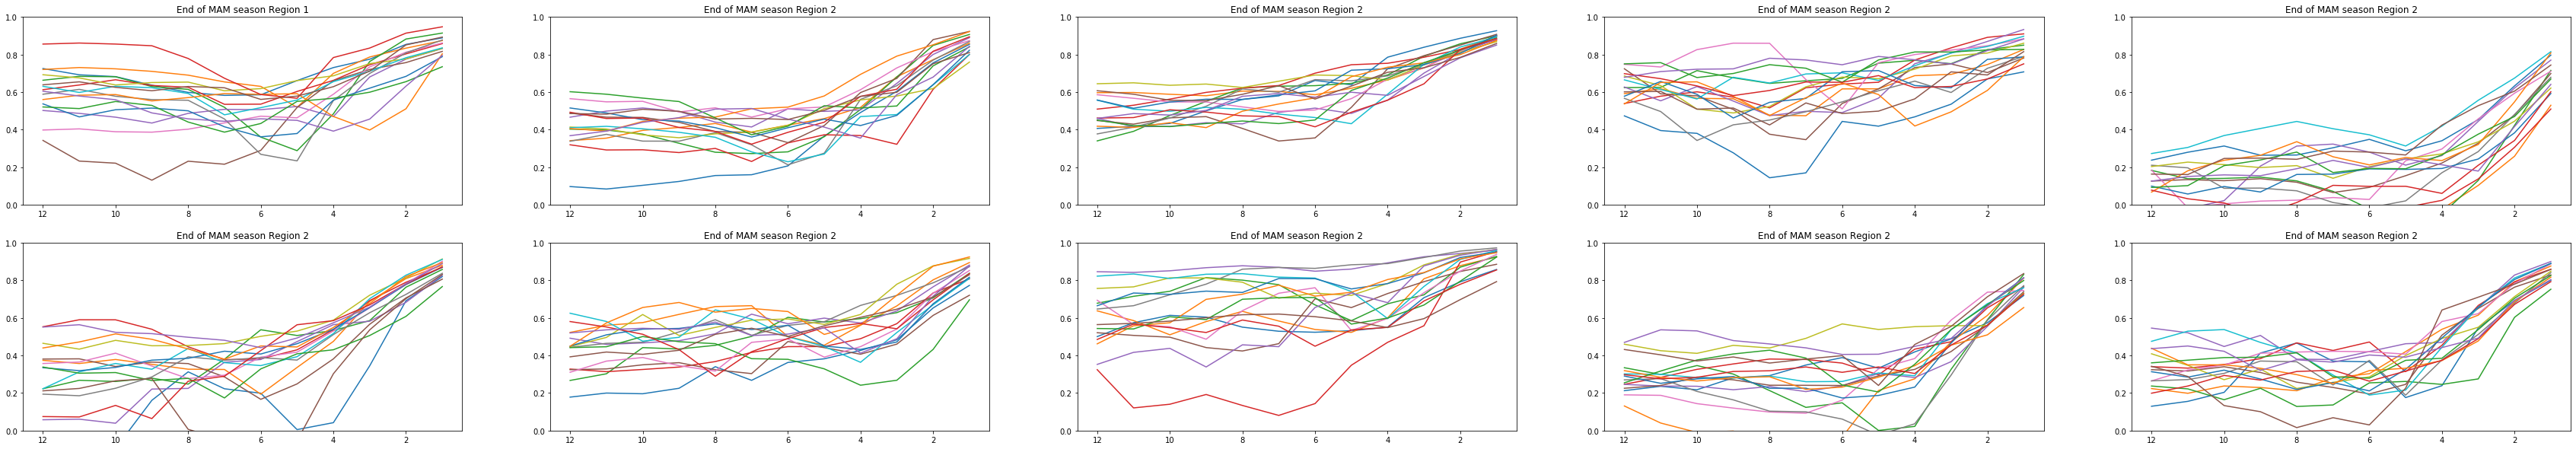

In [172]:
fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, figsize = (60,10))

ax1.plot(list(range(1,13)), rho_5_21_03_reg01, label = '2003')
ax1.plot(list(range(1,13)), rho_5_21_04_reg01, label = '2004')
ax1.plot(list(range(1,13)), rho_5_21_05_reg01, label = '2005')
ax1.plot(list(range(1,13)), rho_5_21_06_reg01, label = '2006')
ax1.plot(list(range(1,13)), rho_5_21_07_reg01, label = '2007')
ax1.plot(list(range(1,13)), rho_5_21_08_reg01, label = '2008')
ax1.plot(list(range(1,13)), rho_5_21_09_reg01, label = '2009')
ax1.plot(list(range(1,13)), rho_5_21_10_reg01, label = '2010')
ax1.plot(list(range(1,13)), rho_5_21_11_reg01, label = '2011')
ax1.plot(list(range(1,13)), rho_5_21_12_reg01, label = '2012')
ax1.plot(list(range(1,13)), rho_5_21_13_reg01, label = '2013')
ax1.plot(list(range(1,13)), rho_5_21_14_reg01, label = '2014')
ax1.plot(list(range(1,13)), rho_5_21_15_reg01, label = '2015')
ax1.plot(list(range(1,13)), rho_5_21_16_reg01, label = '2016')
ax1.plot(list(range(1,13)), rho_5_21_17_reg01, label = '2017')
ax1.plot(list(range(1,13)), rho_5_21_18_reg01, label = '2018')
ax1.invert_xaxis()
ax1.set_title('End of MAM season Region 1')
ax1.set_ylim(0,1)

ax2.plot(list(range(1,13)), rho_5_21_03_reg02, label = '2003')
ax2.plot(list(range(1,13)), rho_5_21_04_reg02, label = '2004')
ax2.plot(list(range(1,13)), rho_5_21_05_reg02, label = '2005')
ax2.plot(list(range(1,13)), rho_5_21_06_reg02, label = '2006')
ax2.plot(list(range(1,13)), rho_5_21_07_reg02, label = '2007')
ax2.plot(list(range(1,13)), rho_5_21_08_reg02, label = '2008')
ax2.plot(list(range(1,13)), rho_5_21_09_reg02, label = '2009')
ax2.plot(list(range(1,13)), rho_5_21_10_reg02, label = '2010')
ax2.plot(list(range(1,13)), rho_5_21_11_reg02, label = '2011')
ax2.plot(list(range(1,13)), rho_5_21_12_reg02, label = '2012')
ax2.plot(list(range(1,13)), rho_5_21_13_reg02, label = '2013')
ax2.plot(list(range(1,13)), rho_5_21_14_reg02, label = '2014')
ax2.plot(list(range(1,13)), rho_5_21_15_reg02, label = '2015')
ax2.plot(list(range(1,13)), rho_5_21_16_reg02, label = '2016')
ax2.plot(list(range(1,13)), rho_5_21_17_reg02, label = '2017')
ax2.plot(list(range(1,13)), rho_5_21_18_reg02, label = '2018')
ax2.invert_xaxis()
ax2.set_title('End of MAM season Region 2')
ax2.set_ylim(0,1)

ax3.plot(list(range(1,13)), rho_5_21_03_reg03, label = '2003')
ax3.plot(list(range(1,13)), rho_5_21_04_reg03, label = '2004')
ax3.plot(list(range(1,13)), rho_5_21_05_reg03, label = '2005')
ax3.plot(list(range(1,13)), rho_5_21_06_reg03, label = '2006')
ax3.plot(list(range(1,13)), rho_5_21_07_reg03, label = '2007')
ax3.plot(list(range(1,13)), rho_5_21_08_reg03, label = '2008')
ax3.plot(list(range(1,13)), rho_5_21_09_reg03, label = '2009')
ax3.plot(list(range(1,13)), rho_5_21_10_reg03, label = '2010')
ax3.plot(list(range(1,13)), rho_5_21_11_reg03, label = '2011')
ax3.plot(list(range(1,13)), rho_5_21_12_reg03, label = '2012')
ax3.plot(list(range(1,13)), rho_5_21_13_reg03, label = '2013')
ax3.plot(list(range(1,13)), rho_5_21_14_reg03, label = '2014')
ax3.plot(list(range(1,13)), rho_5_21_15_reg03, label = '2015')
ax3.plot(list(range(1,13)), rho_5_21_16_reg03, label = '2016')
ax3.plot(list(range(1,13)), rho_5_21_17_reg03, label = '2017')
ax3.plot(list(range(1,13)), rho_5_21_18_reg03, label = '2018')
ax3.invert_xaxis()
ax3.set_title('End of MAM season Region 2')
ax3.set_ylim(0,1)

ax4.plot(list(range(1,13)), rho_5_21_03_reg04, label = '2003')
ax4.plot(list(range(1,13)), rho_5_21_04_reg04, label = '2004')
ax4.plot(list(range(1,13)), rho_5_21_05_reg04, label = '2005')
ax4.plot(list(range(1,13)), rho_5_21_06_reg04, label = '2006')
ax4.plot(list(range(1,13)), rho_5_21_07_reg04, label = '2007')
ax4.plot(list(range(1,13)), rho_5_21_08_reg04, label = '2008')
ax4.plot(list(range(1,13)), rho_5_21_09_reg04, label = '2009')
ax4.plot(list(range(1,13)), rho_5_21_10_reg04, label = '2010')
ax4.plot(list(range(1,13)), rho_5_21_11_reg04, label = '2011')
ax4.plot(list(range(1,13)), rho_5_21_12_reg04, label = '2012')
ax4.plot(list(range(1,13)), rho_5_21_13_reg04, label = '2013')
ax4.plot(list(range(1,13)), rho_5_21_14_reg04, label = '2014')
ax4.plot(list(range(1,13)), rho_5_21_15_reg04, label = '2015')
ax4.plot(list(range(1,13)), rho_5_21_16_reg04, label = '2016')
ax4.plot(list(range(1,13)), rho_5_21_17_reg04, label = '2017')
ax4.plot(list(range(1,13)), rho_5_21_18_reg04, label = '2018')
ax4.invert_xaxis()
ax4.set_title('End of MAM season Region 2')
ax4.set_ylim(0,1)

ax5.plot(list(range(1,13)), rho_5_21_03_reg06, label = '2003')
ax5.plot(list(range(1,13)), rho_5_21_04_reg06, label = '2004')
ax5.plot(list(range(1,13)), rho_5_21_05_reg06, label = '2005')
ax5.plot(list(range(1,13)), rho_5_21_06_reg06, label = '2006')
ax5.plot(list(range(1,13)), rho_5_21_07_reg06, label = '2007')
ax5.plot(list(range(1,13)), rho_5_21_08_reg06, label = '2008')
ax5.plot(list(range(1,13)), rho_5_21_09_reg06, label = '2009')
ax5.plot(list(range(1,13)), rho_5_21_10_reg06, label = '2010')
ax5.plot(list(range(1,13)), rho_5_21_11_reg06, label = '2011')
ax5.plot(list(range(1,13)), rho_5_21_12_reg06, label = '2012')
ax5.plot(list(range(1,13)), rho_5_21_13_reg06, label = '2013')
ax5.plot(list(range(1,13)), rho_5_21_14_reg06, label = '2014')
ax5.plot(list(range(1,13)), rho_5_21_15_reg06, label = '2015')
ax5.plot(list(range(1,13)), rho_5_21_16_reg06, label = '2016')
ax5.plot(list(range(1,13)), rho_5_21_17_reg06, label = '2017')
ax5.plot(list(range(1,13)), rho_5_21_18_reg06, label = '2018')
ax5.invert_xaxis()
ax5.set_title('End of MAM season Region 2')
ax5.set_ylim(0,1)

ax6.plot(list(range(1,13)), rho_5_21_03_reg07, label = '2003')
ax6.plot(list(range(1,13)), rho_5_21_04_reg07, label = '2004')
ax6.plot(list(range(1,13)), rho_5_21_05_reg07, label = '2005')
ax6.plot(list(range(1,13)), rho_5_21_06_reg07, label = '2006')
ax6.plot(list(range(1,13)), rho_5_21_07_reg07, label = '2007')
ax6.plot(list(range(1,13)), rho_5_21_08_reg07, label = '2008')
ax6.plot(list(range(1,13)), rho_5_21_09_reg07, label = '2009')
ax6.plot(list(range(1,13)), rho_5_21_10_reg07, label = '2010')
ax6.plot(list(range(1,13)), rho_5_21_11_reg07, label = '2011')
ax6.plot(list(range(1,13)), rho_5_21_12_reg07, label = '2012')
ax6.plot(list(range(1,13)), rho_5_21_13_reg07, label = '2013')
ax6.plot(list(range(1,13)), rho_5_21_14_reg07, label = '2014')
ax6.plot(list(range(1,13)), rho_5_21_15_reg07, label = '2015')
ax6.plot(list(range(1,13)), rho_5_21_16_reg07, label = '2016')
ax6.plot(list(range(1,13)), rho_5_21_17_reg07, label = '2017')
ax6.plot(list(range(1,13)), rho_5_21_18_reg07, label = '2018')
ax6.invert_xaxis()
ax6.set_title('End of MAM season Region 2')
ax6.set_ylim(0,1)

ax7.plot(list(range(1,13)), rho_5_21_03_reg08, label = '2003')
ax7.plot(list(range(1,13)), rho_5_21_04_reg08, label = '2004')
ax7.plot(list(range(1,13)), rho_5_21_05_reg08, label = '2005')
ax7.plot(list(range(1,13)), rho_5_21_06_reg08, label = '2006')
ax7.plot(list(range(1,13)), rho_5_21_07_reg08, label = '2007')
ax7.plot(list(range(1,13)), rho_5_21_08_reg08, label = '2008')
ax7.plot(list(range(1,13)), rho_5_21_09_reg08, label = '2009')
ax7.plot(list(range(1,13)), rho_5_21_10_reg08, label = '2010')
ax7.plot(list(range(1,13)), rho_5_21_11_reg08, label = '2011')
ax7.plot(list(range(1,13)), rho_5_21_12_reg08, label = '2012')
ax7.plot(list(range(1,13)), rho_5_21_13_reg08, label = '2013')
ax7.plot(list(range(1,13)), rho_5_21_14_reg08, label = '2014')
ax7.plot(list(range(1,13)), rho_5_21_15_reg08, label = '2015')
ax7.plot(list(range(1,13)), rho_5_21_16_reg08, label = '2016')
ax7.plot(list(range(1,13)), rho_5_21_17_reg08, label = '2017')
ax7.plot(list(range(1,13)), rho_5_21_18_reg08, label = '2018')
ax7.invert_xaxis()
ax7.set_title('End of MAM season Region 2')
ax7.set_ylim(0,1)

ax8.plot(list(range(1,13)), rho_5_21_03_reg10, label = '2003')
ax8.plot(list(range(1,13)), rho_5_21_04_reg10, label = '2004')
ax8.plot(list(range(1,13)), rho_5_21_05_reg10, label = '2005')
ax8.plot(list(range(1,13)), rho_5_21_06_reg10, label = '2006')
ax8.plot(list(range(1,13)), rho_5_21_07_reg10, label = '2007')
ax8.plot(list(range(1,13)), rho_5_21_08_reg10, label = '2008')
ax8.plot(list(range(1,13)), rho_5_21_09_reg10, label = '2009')
ax8.plot(list(range(1,13)), rho_5_21_10_reg10, label = '2010')
ax8.plot(list(range(1,13)), rho_5_21_11_reg10, label = '2011')
ax8.plot(list(range(1,13)), rho_5_21_12_reg10, label = '2012')
ax8.plot(list(range(1,13)), rho_5_21_13_reg10, label = '2013')
ax8.plot(list(range(1,13)), rho_5_21_14_reg10, label = '2014')
ax8.plot(list(range(1,13)), rho_5_21_15_reg10, label = '2015')
ax8.plot(list(range(1,13)), rho_5_21_16_reg10, label = '2016')
ax8.plot(list(range(1,13)), rho_5_21_17_reg10, label = '2017')
ax8.plot(list(range(1,13)), rho_5_21_18_reg10, label = '2018')
ax8.invert_xaxis()
ax8.set_title('End of MAM season Region 2')
ax8.set_ylim(0,1)

ax9.plot(list(range(1,13)), rho_5_21_03_reg11, label = '2003')
ax9.plot(list(range(1,13)), rho_5_21_04_reg11, label = '2004')
ax9.plot(list(range(1,13)), rho_5_21_05_reg11, label = '2005')
ax9.plot(list(range(1,13)), rho_5_21_06_reg11, label = '2006')
ax9.plot(list(range(1,13)), rho_5_21_07_reg11, label = '2007')
ax9.plot(list(range(1,13)), rho_5_21_08_reg11, label = '2008')
ax9.plot(list(range(1,13)), rho_5_21_09_reg11, label = '2009')
ax9.plot(list(range(1,13)), rho_5_21_10_reg11, label = '2010')
ax9.plot(list(range(1,13)), rho_5_21_11_reg11, label = '2011')
ax9.plot(list(range(1,13)), rho_5_21_12_reg11, label = '2012')
ax9.plot(list(range(1,13)), rho_5_21_13_reg11, label = '2013')
ax9.plot(list(range(1,13)), rho_5_21_14_reg11, label = '2014')
ax9.plot(list(range(1,13)), rho_5_21_15_reg11, label = '2015')
ax9.plot(list(range(1,13)), rho_5_21_16_reg11, label = '2016')
ax9.plot(list(range(1,13)), rho_5_21_17_reg11, label = '2017')
ax9.plot(list(range(1,13)), rho_5_21_18_reg11, label = '2018')
ax9.invert_xaxis()
ax9.set_title('End of MAM season Region 2')
ax9.set_ylim(0,1)

ax10.plot(list(range(1,13)), rho_5_21_03_reg12, label = '2003')
ax10.plot(list(range(1,13)), rho_5_21_04_reg12, label = '2004')
ax10.plot(list(range(1,13)), rho_5_21_05_reg12, label = '2005')
ax10.plot(list(range(1,13)), rho_5_21_06_reg12, label = '2006')
ax10.plot(list(range(1,13)), rho_5_21_07_reg12, label = '2007')
ax10.plot(list(range(1,13)), rho_5_21_08_reg12, label = '2008')
ax10.plot(list(range(1,13)), rho_5_21_09_reg12, label = '2009')
ax10.plot(list(range(1,13)), rho_5_21_10_reg12, label = '2010')
ax10.plot(list(range(1,13)), rho_5_21_11_reg12, label = '2011')
ax10.plot(list(range(1,13)), rho_5_21_12_reg12, label = '2012')
ax10.plot(list(range(1,13)), rho_5_21_13_reg12, label = '2013')
ax10.plot(list(range(1,13)), rho_5_21_14_reg12, label = '2014')
ax10.plot(list(range(1,13)), rho_5_21_15_reg12, label = '2015')
ax10.plot(list(range(1,13)), rho_5_21_16_reg12, label = '2016')
ax10.plot(list(range(1,13)), rho_5_21_17_reg12, label = '2017')
ax10.plot(list(range(1,13)), rho_5_21_18_reg12, label = '2018')
ax10.invert_xaxis()
ax10.set_title('End of MAM season Region 2')
ax10.set_ylim(0,1)